# Importing packages

In [1]:
# Importing packages
import matplotlib.pyplot as plt # seams to be the most used
import matplotlib as mpl # did not dare to mess with plt comand
#plt.style.use('ggplot')
import seaborn as sns
# sns.set(style='whitegrid')
#sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.lines as mlines
import matplotlib.ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
from matplotlib import dates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
#import plotnine as p9 # Same as ggplot
import pandas as pd
import numpy as np
import math
from scipy.signal import medfilt
import scipy.stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import glob
import re


# To get untruncated output from pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Normal Setting global font size for plots
plt.rcParams['font.sans-serif'] = 'Arial'
small_size = 12
medium_size = 14
large_size = 16
plt.rc('axes', titlesize=large_size)     # fontsize of the axes title
plt.rc('axes', labelsize=large_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=medium_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=medium_size)    # fontsize of the tick labels
plt.rc('legend',fontsize=medium_size)      # fontsize of the legend'
plt.rcParams['axes.xmargin'] = 0         # get rid of margins befor and after data along x-axis
# plt.rcParams["axes.grid"] = False     # remove grid of plots

# remove grid but keep tick marks for the axes
color = 'black'
plt.rc('axes', grid=False, edgecolor=color)
plt.rc('xtick', bottom=True, top=False, color=color)  # Show bottom ticks and hide top ticks for all plots
plt.rc('ytick', left=True, right=False, color=color)  # Show left ticks and hide right ticks for all plots
plt.rc('xtick', labelcolor=color)  # Set x tick label color to black
plt.rc('ytick', labelcolor=color)

colors= ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00','#000000','#BBBBBB'] # https://nanx.me/oneclust/reference/cud.html

# # POSTER Setting global font size for plots
# medium_size = 26
# large_size = 30
# plt.rc('axes', titlesize=large_size)     # fontsize of the axes title
# plt.rc('axes', labelsize=large_size)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=medium_size)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=medium_size)    # fontsize of the tick labels
# plt.rc('legend',fontsize=medium_size)      # fontsize of the legend'
# plt.rcParams['axes.xmargin'] = 0         # get rid of margins befor and after data along x-axis


# LOADING FUNCTIONS
def sub_sample_df_old(df, moduleMask): # insert dataframe and mask for dataframe
    modules = df[moduleMask]
    if 'Displacement [mm]:' in df.columns:
        subSample = modules[['Date:', 'Displacement [mm]:']]
    if 'Water table [m bgl]:' in df.columns:
        subSample = modules[['Date:', 'Module ID:', 'Water table [m bgl]:']]
    subSample = subSample.set_index('Date:')
    return subSample

# SUBSAMPLING DF's       NEW
def sub_sample_df(df, modules): # insert dataframe and mask for dataframe
    khlist = []
    modules = modules
    for i in modules:
        file = df
        module = i
        moduleMask = file['Module ID:'].isin([module])
        file = file[moduleMask]
        file.set_index('Date:', inplace=True)
        file = file.resample('1h').median()    
        khlist.append(file) # adding modules to list
    df = pd.concat(khlist, axis=1)
    
    # inclinometers
    if 'Displacement [mm]:' in df.columns:
        subSample = df[['Displacement [mm]:']]
    
    # piezometers
    if 'Water table [m bgl]:' in df.columns:
        subSample = df[['Water table [m bgl]:']]
    
    return subSample

# Slice df by time_start and time_end 
def sub_set_df(df, time_start=1, time_end=2):
    mask = (df.index > time_start) & (df.index <= time_end)
    return df[mask]

# # Statsmodel, linear regression over n hours defined by window_hours
# from statsmodels.formula.api import ols
# def linearfit(volume, window_days=0.5, results = False, gps=False):
#     volume = volume.to_frame()
#     df = volume.dropna()
#     df = df.reset_index(drop=True) # due to LinearRgression is not able to calculate with dateformat as x-axis
#     if gps is True:
#         window_hours = 2*window_days
#     else:
#         window_hours = 24*window_days 
#     cutoff_start = df.index.values[0]
#     cutoff_end = cutoff_start + window_hours
#     reg_res = []
#     data_left = True

#     # Slicing timeseries by window_hours calculating linear regression with slope, intercept and r^2                                                                           
#     while data_left:
#         if cutoff_end > df.index.values[-1]:
#             data_left = False
#             cutoff_end = df.index.values[-1]
#             break   
#         start = df.index.values >= cutoff_start
#         end = df.index.values <= cutoff_end
#         current_data = df[start & end]
#         if len(current_data) > window_hours-1:
#             mod = sm.OLS(y, sm.add_constant(X))
#             mod = ols(formula = 'current_data.values ~ current_data.index', data = current_data) # model
#             fit = mod.fit() # model fit
#             if results is True:
#                 reg_res += [(cutoff_start+window_hours//2, fit.params[1], fit.params[0], fit.rsquared)]  # returns intercept and r^2 in addition to index and slope
#             else:
#                 reg_res += [(cutoff_start+window_hours//2, fit.params[1])]  # returns index and slope
#         cutoff_start += 1
#         cutoff_end = cutoff_start + window_hours

#     # Merging df and reg_res to obtain correct index and storing output from linear regression and calculating error of fit
#     df.index.name = 'index'
#     df[volume.index.name] = volume.index
#     slopedf = pd.DataFrame(reg_res)
#     if results is True:
#         slopedf.columns = ['index',f'{window_days}_days_velocity', 'intercept', 'r^2'] # NB velocity is the slope of the fit
#         slopedf['y_fit'] = slopedf[f'{window_days}_days_velocity']*slopedf.index+slopedf['intercept']
#         df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
#         df_merged.set_index(volume.index.name,inplace=True, drop=True)
#         df_merged['residuals'] = (df_merged.iloc[:,[1]].values-df_merged.iloc[:,[5]].values) # y-y_hat = resuduals
#         df_merged['error_of_fit'] = ((np.mean(df_merged['residuals']**2))**(1/2))
#         df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna()
#     else:
#         slopedf.columns = ['index',f'{window_days}_days_velocity']
#         df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
#         df_merged.set_index(volume.index.name,inplace=True, drop=True)
#         df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna()

# NEW VERSION !

# Statsmodel, linear regression over n hours defined by window_hours
from statsmodels.formula.api import ols
def linearfit(volume, window_days=0.5, results = False, gps=False): # added gps= to get rows that fit gps days velocity
    volume = volume.to_frame()
    df = volume.copy()
    df = df.reset_index(drop=True) # due to LinearRgression is not able to calculate with dateformat as x-axis
    if gps is True:
        window_hours = 2*window_days
    else:
        window_hours = 24*window_days 
    cutoff_start = df.index.values[0]
    cutoff_end = cutoff_start + window_hours
    reg_res = []
    data_left = True # starts loop

    # Slicing timeseries by window_hours calculating linear regression with slope, intercept and r^2                                                                           
    while data_left:
        if cutoff_end > df.index.values[-1]:
            data_left = False # stops loop
            cutoff_end = df.index.values[-1]
            break   
        start = df.index.values >= cutoff_start
        end = df.index.values <= cutoff_end
        current_data = df[start & end]
        current_data = current_data.squeeze()
        # added part so no need of interpolation, but perhaps for boreholes?
        if max(current_data.isnull().astype(int).groupby(current_data.notnull().astype(int).cumsum()).cumsum()) > window_hours/4: # True if more than consecutive nans
            current_data = current_data.dropna(axis=0) # deletes nan so df is to small to get true in next if statement
        
        if len(current_data) > window_hours-1:
            mod = ols(formula = 'current_data.values ~ current_data.index', data = current_data) # model
            fit = mod.fit() # model fit
            if results is True:
                reg_res += [(cutoff_start+window_hours//2, fit.params.iloc[1], fit.params.iloc[0], fit.rsquared)]  # returns intercept and r^2 in addition to index and slope
            else:
                reg_res += [(cutoff_start+window_hours//2, fit.params.iloc[1])]  # returns index and slope
        cutoff_start += 1
        cutoff_end = cutoff_start + window_hours

    # Merging df and reg_res to obtain correct index and storing output from linear regression and calculating error of fit
    df.index.name = 'index'
    df[volume.index.name] = volume.index
    slopedf = pd.DataFrame(reg_res)
    if results is True:
        slopedf.columns = ['index',f'{window_days}_days_velocity', 'intercept', 'r^2'] # NB velocity is the slope of the fit
        slopedf['y_fit'] = slopedf[f'{window_days}_days_velocity']*slopedf.index+slopedf['intercept']
        df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
        df_merged.set_index(volume.index.name,inplace=True, drop=True)
        df_merged['residuals'] = (df_merged.iloc[:,[1]].values-df_merged.iloc[:,[5]].values) # y-y_hat = resuduals
        df_merged['error_of_fit'] = ((np.mean(df_merged['residuals']**2))**(1/2))
        df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna() # this might be a problem in the future.. But I will comment it and get data with nans
        return df_merged
    else:
        slopedf.columns = ['index',f'{window_days}_days_velocity']
        df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
        df_merged.set_index(volume.index.name,inplace=True, drop=True)
        df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna() # this might be a problem in the future.. But I will comment it and get data with nans
        return df_merged
    
# cross correlation and its p-value
def pearsonr_crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag), method='pearson')

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def pearsonr_crosscorr_pval(datax, datay, lag=0):
    return datax.corr(datay.shift(lag), method=pearsonr_pval)

def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# STA/LTA FILTER WITH CREEP BURST THRESHOLD 
def sta_lta(df, STA=2, LTA=60, detrigg_on=True, trigg=2, detrigg=1, threshold_dynamic=True):
    df = pd.merge_asof(df, linearfit(df['displacement_butterfilt'], window_days=LTA), on=df.index.name, tolerance=pd.Timedelta(hours=0))
    
    # add STA if it is not in the df
    if not f'{STA}_days_velocity' in df.columns:
        df.set_index(df.columns[0], drop=True, inplace=True)
        df = pd.merge_asof(df, linearfit(df['displacement_butterfilt'], window_days=STA), on=df.index.name, tolerance=pd.Timedelta(hours=0))
    
    # setting STA and LTA 
    df['sta'] = df[f'{STA}_days_velocity'].values # use 1_day or 2_days ?
    df['lta'] = df[f'{LTA}_days_velocity'].values
#     df.loc[:, 'lta'] = df[f'{LTA}_days_velocity'].shift(LTA*24//2) # shifts lta to start at end of window, not middle. This was used in seismology but did not seam to work as well on our time series
    df['sta/lta'] = df['sta']/df['lta']
    
    # creep burst threshold
    df['trigger'] = np.nan
    df['detrigger'] = np.nan
    
    if threshold_dynamic is True:
        # dynamic threshold
        window_length = LTA*24 # the start of mean calculation
        for i,d in enumerate(df['sta/lta'][window_length+window_length//2:-window_length//2]):
            # window from start to end of sta/lta
            window = df.loc[i+window_length:i+window_length*2, 'sta/lta']
            sigma = np.sqrt((np.sum(np.square(window-np.mean(window))))/len(window-1))
            # inserting mean + sigma in center of window
            df.loc[i+window_length+window_length//2, 'trigger'] = np.mean(window)+sigma*trigg # 2 x SD centered 
            df.loc[i+window_length+window_length//2, 'detrigger'] = np.mean(window)+sigma*detrigg # 1 x SD centered
    else:
        # static threshold
        sigma = np.sqrt((np.sum(np.square(df['sta/lta']-np.mean(df['sta/lta']))))/len(df['sta/lta']-1))
        df['trigger'] = np.mean(df['sta/lta'])+sigma*trigg
        df['detrigger'] = np.mean(df['sta/lta'])+sigma*detrigg
    
    # selecting creep bursts
    df['nBursts'] = 0
    prev_d = 0
    prev_burst_idx = 0
    indexes = []
    above_trigg = False
    
    if detrigg_on is True:
        for i, d in enumerate(df['sta/lta']):
            # trigger threshold
            if d > df.loc[i, 'detrigger']:
                indexes += [i]
                if d > df.loc[i, 'trigger']:
                    above_trigg = True
            else:
                if above_trigg:
                    df.loc[indexes, 'nBursts'] = 1
                indexes = []
                above_trigg = False
    df.set_index(df.columns[0], drop=True, inplace=True)
    return df

def velocity(df, window_days=4, results=True):
    df =  pd.merge_asof(df, linearfit(df['displacement_butterfilt'], window_days=window_days, results=results), on=df.index.name, tolerance=pd.Timedelta(hours=0)) #results=True to get additional results
    df.set_index(df.columns[0], drop=True, inplace=True) # reinsetting the datetime index
    return df

# When agreed on how it should look like, make this a part of the pre_plotting script

def creep_database(df, STA):
    
    # time resolution
    hours = 60*60 # in hours
    days = hours*24 # in days

    # fetching creep events
    window = []
    previous_d = 0
    for i, d in enumerate(df['nBursts']):
            if d != previous_d:
                previous_d = d
                window.append(df.index[i:i+1])
    # creating database of creep bursts
    idx = np.arange(0, len(window), 2)  # index to slice at even numbers
    idx2 = np.arange(0, len(idx), 1)

    creep_database = pd.DataFrame(idx2, columns=['event']) # length of df
    date_start = []
    date_end = []
    duration = []
    duration_days = []
    date = []
    displacement_start = []
    displacement = []
    velocity = []
    velocity_days = []
    slip_distance = []

    # loading each event and saving data to database
    for start in idx:
        creep_event = df.loc[window[start][0]:window[start+1][0]] # the last row in df is not part of creep burst event
        date_start.append(creep_event.index[0])
        date_end.append(creep_event.index[-1])
        duration.append((creep_event.index[-1]-creep_event.index[0]).total_seconds()//hours) # duration in hours
        duration_days.append((creep_event.index[-1]-creep_event.index[0]).total_seconds()//days) # duration in days
        date.append((creep_event.index[:-1]-creep_event.index[0]).total_seconds()//hours) # to be able to plot each event
        displacement_start.append(creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].first_valid_index()]) # to make plotting on top of entire dataseries easier
        displacement.append(creep_event['displacement_butterfilt'][:-1].values-
                            creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].first_valid_index()]) # to be able to plot each event
        slip_distance.append(creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].last_valid_index()]-
                             creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].first_valid_index()]) # total displacement
        velocity.append(np.nanmax(creep_event[f'{STA}_days_velocity'][:-1])) # max velocity for 'n_days_velocity' per day

    creep_database['date_start'] = date_start
    creep_database['date_end'] = date_end
    creep_database['duration'] = duration
    creep_database['date'] = date # to be able to plot each event
    creep_database['displacement_start'] = displacement_start # to be able to plot each event ontop of entire timeseries
    creep_database['displacement'] = displacement # to be able to plot each event
    creep_database['total_slip_distance'] = slip_distance
    creep_database['max_velocity'] = velocity
#     # the below are for the creep database plots in days
    creep_database['duration_days'] = duration_days 
    creep_database['nEvents'] = 1
    
    return creep_database


# function to sum for two months (window_days). Used for seismics and surface runoff
def sum_period(volume, window_days=60):
    volume = volume.to_frame()
    window_hours = 24*window_days
    df = volume.copy()
    df = df.reset_index(drop=True)
    cutoff_start = df.index.values[0]
    cutoff_end = cutoff_start + window_hours
    summed_data = []
    data_left = True # starts loop

    # Slicing timeseries by window_hours calculating linear regression with slope, intercept and r^2                                                                           
    while data_left:
        if cutoff_end > df.index.values[-1]:
            data_left = False # stops loop
            cutoff_end = df.index.values[-1]
            break   
        start = df.index.values >= cutoff_start
        end = df.index.values <= cutoff_end
        current_data = df[start & end]
        current_data = current_data.squeeze()

        if max(current_data.isnull().astype(int).groupby(current_data.notnull().astype(int).cumsum()).cumsum()) > window_hours/4: # True if more than consecutive nans
                current_data = current_data.dropna(axis=0) # deletes nan so df is to small to get true in next if statement

        if len(current_data) > window_hours-1:
            summed = current_data.sum()
            summed_data += [(cutoff_start+window_hours//2, summed)]  # returns index and summation of events in the time window, 1 month before and after, so centered
        cutoff_start += 1
        cutoff_end = cutoff_start + window_hours

    # Merging df and reg_res to obtain correct index and storing output from linear regression and calculating error of fit
    df.index.name = 'index'
    df[volume.index.name] = volume.index # make same name for both indexes to be able to merge on name
    new_df = pd.DataFrame(summed_data)

    new_df.columns = ['index',f'{window_days}_days_summed']
    df_merged = pd.merge_asof(df,new_df, on=df.index.name, tolerance=0)
    df_merged.set_index(volume.index.name,inplace=True, drop=True)
    df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
    return df_merged

def reindexing_1h(df):
    idx = pd.date_range(start=df.index[0],end=df.index[-1],freq='1h')
    df = df.reindex(idx)
    return df

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

## Loading Jettan and Gamanjunni

In [2]:
# seismic data
path = 'Seismic_analysis\\'  # set folder related to script location
seismic = pd.read_csv(path + 'dvvJETT_03-07Hz.txt', sep='\t') 
seismic['Datetime'] = pd.to_datetime(seismic['Datetime'], format='%d.%m.%y', errors='coerce')
seismic = seismic.set_index('Datetime')
seismic = seismic.drop(columns=['datetime(Matlab_format)'])

path = 'pre_plotting\\'  # set folder related to script location

extension = '.pkl'

## GPS
# 12 hour data
jtt_gps2 = pd.read_pickle(path + 'jett_gps_2' + extension)
jtt_gps3 = pd.read_pickle(path + 'jett_gps_3' + extension)
jtt_gps4 = pd.read_pickle(path + 'jett_gps_4' + extension)
jtt_gps5 = pd.read_pickle(path + 'jett_gps_5' + extension)
jtt_gps6 = pd.read_pickle(path + 'jett_gps_6' + extension)
jtt_gps7 = pd.read_pickle(path + 'jett_gps_7' + extension)
jtt_gps8 = pd.read_pickle(path + 'jett_gps_8' + extension)
jtt_gps9 = pd.read_pickle(path + 'jett_gps_9' + extension)
jtt_gps10 = pd.read_pickle(path + 'jett_gps_10' + extension)
jtt_gps11 = pd.read_pickle(path + 'jett_gps_11' + extension)

# gam_gps3 = pd.read_pickle(path + 'gam_gps_3' + extension)
# gam_gps4 = pd.read_pickle(path + 'gam_gps_4' + extension)
# gam_gps5 = pd.read_pickle(path + 'gam_gps_5' + extension)
# gam_gps6 = pd.read_pickle(path + 'gam_gps_6' + extension)
# gam_gps7 = pd.read_pickle(path + 'gam_gps_7' + extension)
# gam_gps8 = pd.read_pickle(path + 'gam_gps_8' + extension)
# gam_gps9 = pd.read_pickle(path + 'gam_gps_9' + extension)
# gam_gps10 = pd.read_pickle(path + 'gam_gps_10' + extension)

# # ak_gps4 = pd.read_pickle(path + 'ak_gps_4' + extension)
# # ak_gps5 = pd.read_pickle(path + 'ak_gps_5' + extension)

# # # 4 hour data
# # gps3_4h = pd.read_pickle(path + 'gps3_4h' + extension)
# # gps4_4h = pd.read_pickle(path + 'gps4_4h' + extension)

## Meteorological data from Senorge (real data) and XGEO (Modeled weather data that is better than the cautus weather station)
jtt_xgeo_rain = pd.read_pickle(path + 'xgeo_rain' + extension)
jtt_xgeo_temp = pd.read_pickle(path + 'xgeo_temp' + extension)
jtt_xgeo_snow = pd.read_pickle(path + 'xgeo_snow' + extension)
jtt_temp = pd.read_pickle(path + 'jtt_temp' + extension)
jtt_precip = pd.read_pickle(path + 'jtt_precip' + extension)
jtt_snow = pd.read_pickle(path + 'jtt_snow' + extension)
jtt_xgeo_surfacerunnoff = pd.read_pickle(path + 'xgeo_surfacerunnoff' + extension)
JT_CLM_1 = pd.read_pickle(path + 'JT_CLM_1' + extension)
ST = pd.read_pickle(path + 'ST' + extension)
tlt2_temp = pd.read_pickle(path + 'tlt2_temp' + extension)
tlt9_temp = pd.read_pickle(path + 'tlt9_temp' + extension)
hobos = pd.read_pickle(path + 'hobos' + extension)
temp1 = pd.read_pickle(path + 'temp1' + extension)

# river data measurements
river1 = pd.read_pickle(path + 'river1' + extension)
river2 = pd.read_pickle(path + 'river2' + extension)

# ## Borholes
# Raw is without filtered and without raw is filtered
# Jettan
JTT1Disp = pd.read_pickle(path + 'JTT1Disp_raw' + extension)
JTT1Wp = pd.read_pickle(path + 'JTT1Wp_raw' + extension)

JTT2DispUpperZone = pd.read_pickle(path + 'JTT2DispUpperZone_raw' + extension)
JTT2WpUpperZone = pd.read_pickle(path + 'JTT2WpUpperZone_raw' + extension)

JTT2DispLowerZone = pd.read_pickle(path + 'JTT2DispLowerZone_raw' + extension)
JTT2WpLowerZone = pd.read_pickle(path + 'JTT2WpLowerZone_raw' + extension)

JTT3Disp = pd.read_pickle(path + 'JTT3Disp_raw' + extension)
JTT3Wp = pd.read_pickle(path + 'JTT3Wp_raw' + extension)

### Figure X, JTT1 climatic parameters on 2022 acceleration

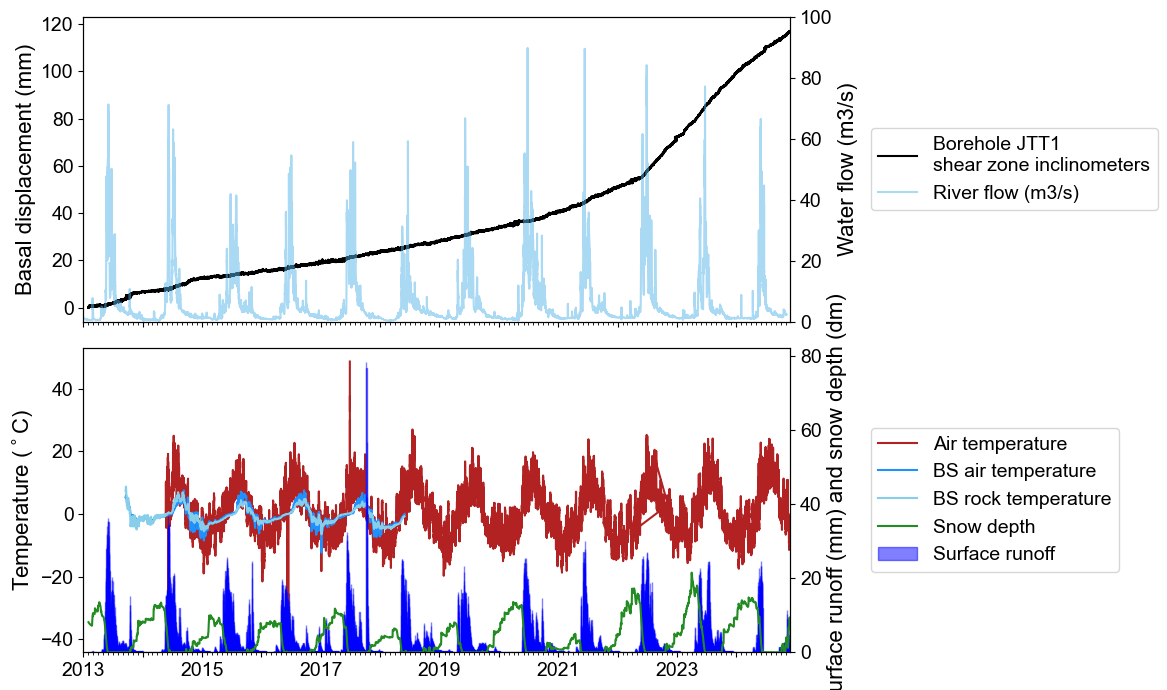

In [333]:
from matplotlib.dates import DateFormatter

# # DATA
start_time = JTT1Disp.index[0]
end_time = JTT1Disp.index[-1]

# water level
n_day = 31 # days # 2 months kernel size for median filter (hourly data)
n_hour = round_up_to_odd(24*n_day) 

# plotting

fig, ax = plt.subplots(nrows=2, figsize=(12,7), sharex=True)
# fig.subplots_adjust(hspace=0) #fig.subplots_adjust(wspace=0) # to remove space on each side of the x-axis

#######                          PLOT 1                           #######
file = []
file2 = [] # to make sure it does not come from previous plot

# JTT1
# file = JTT1Disp_creep.copy()
file2 = JTT1Disp.copy()

# #JTT3
# file = JTT3Disp_creep.copy()
# file2 = JTT3Disp.copy()

# # JTT2 Upper
# file = JTT2DispUpperZone_creep.copy()
# file2 = JTT2DispUpperZone.copy()

# Want this behind
ax_y0 = ax[0].twinx()
file3 = JTT1Wp.copy()
watermodule = 'Mod4_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file3 = file3.replace(np.nan,np.inf) # changing nan to inf
# ax_y0.plot(file3.index, file3.values-np.nanmin(file3.values), color=colors[4], label='Water pressure', alpha=0.5) # does not show any change, only 1 m above sensor..

df = river1.copy()
# df.iloc[:,0] = medfilt(df.iloc[:,0], kernel_size=n_day)
ax_y0.plot(df.index, df.iloc[:,0], color=colors[5], label='River flow (m3/s)', alpha=0.5)

# Want this in front
zero_start = file2['Disp_summed [mm]:'][0] # starting from 0
df = file2.copy()
# df.loc[df['interpolated_disp'] >0] = np.inf
ax[0].plot(df.index, df['Disp_summed [mm]:']-zero_start, color='black', label='Borehole JTT1 \nshear zone inclinometers')
# df = file2.copy()
# df.loc[df['interpolated_disp'] ==np.nan] = np.inf
# ax[1].plot(df.index, df['interpolated_disp']-zero_start, color='violet', label='Interpolated displacement')

# # df of start and end of bursts
# window = []
# previous_d = 0
# for i, d in enumerate(file2['nBursts']):
#     if d != previous_d:
#         previous_d = d
#         window.append(file2[i:i+1].index)

# # Convert the list of datetime objects to a NumPy array
# window = np.array([item[0] for item in window])
        
# idx = np.arange(0, len(window), 2)  # index to slice at even numbers
# for start in idx:
#     ax[0].axvspan(window[start], window[start+1], facecolor='lightcoral', edgecolor='lightcoral', label='Creep burst', zorder=3, alpha=0.4)

# df = file2.copy()
# df.loc[df['nBursts'] ==0] = np.nan
# df = df.replace(np.nan,np.inf) # to avoid interpolation between holes in data
# ax[0].plot(df.index, df['Disp_summed [mm]:']-zero_start, color='crimson', label='', zorder=2) # I do not know if we want this coloring?

# # df of missing data
# df = file2['Disp_summed [mm]:'].copy()
# df.loc[df.notna()] = 0
# df.loc[df.isna()] = 1
# window = []
# previous_d = 0
# zero_start = mpl.dates.date2num(df.index[0])

# for i, d in enumerate(df):
#     if d != previous_d:
#         previous_d = d
#         window.append(df[i:i+1].index)

# # Convert the list of datetime objects to a NumPy array
# window = np.array([item[0] for item in window])

# idx = np.arange(0, len(window), 2)  # index to slice at even numbers
# for start in idx[:-1]:
#     if window[start+1]-window[start] > np.timedelta64(1, 'h'): # can change to show only more than n hours..
#         xmin = (mpl.dates.date2num(window[start])-zero_start)/(mpl.dates.date2num(df.index[-1])-zero_start)
#         xmax = (mpl.dates.date2num(window[start+1])-zero_start)/(mpl.dates.date2num(df.index[-1])-zero_start)
#         ax[0].axhspan(ymin=-file2['Disp_summed [mm]:'].max()/40, ymax=0, xmin=xmin, xmax=xmax, facecolor='gray', edgecolor='gray', label='Missing data', zorder=1, alpha=0.4) # zorder = what layer to plot from back to front

# # Cumulated plot, not to be used as of now..
# df = file.copy()
# frames = []
# for i in df.index:
#     cb = pd.DataFrame(index=pd.date_range(file['date_start'][i], periods=len(file['date'][i].values), freq='H'))
#     cb['displacement'] = df.displacement.iloc[i]
#     frames.append(cb)
# cb = pd.concat(frames)
# cb['displacement'] = cb['displacement'].replace(0, np.nan).dropna()
# velocity = cb['displacement'].shift(-1)-cb['displacement']
# cb['cumulated'] = np.nancumsum(velocity) # cumulated creep bursts
# # ax[1].plot(cb.index, cb['cumulated'], color='crimson', label='Cumulated creep bursts')
# df = file2.copy()
# df.loc[df['nBursts'] ==1] = np.nan
# velocity = df['Disp_summed [mm]:'].shift(-1)-df['Disp_summed [mm]:']
# df['cumulated'] = np.nancumsum(velocity) # cumulated disp w/o creep burst
# # ax[1].plot(df.index, df['cumulated'], color='black', label='Displacement w/o bursts')

# cb_of_totaldisp = (cb['cumulated'][-1]/df['cumulated'][-1])*100
# # ax[0].text(pd.Timestamp('2020-02-05'), 90, f'Creep bursts contribute to {cb_of_totaldisp:.1f} % of total displacement' , horizontalalignment='left', size='medium', color='black', fontsize=medium_size)

#######                          PLOT 2                           #######

width = 55/60*1 # n_day # 55 works well for 60 days
# temp_sub =  temp[(temp.index > start_time) & (temp.index < end_time)] # data per day
temp_sub = jtt_temp.copy() #[jtt_temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
# temp_sub.iloc[:,0] = medfilt(temp_sub.iloc[:,0], kernel_size=n_day)

ST_sub = ST[ST.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
# ST_sub.iloc[:,0] = medfilt(ST_sub.iloc[:,0], kernel_size=n_day)
# ST_sub.iloc[:,1] = medfilt(ST_sub.iloc[:,1], kernel_size=n_day)

ax[1].plot(temp_sub.index, temp_sub['temperature'], color='firebrick', label='Air temperature')
ax[1].plot(ST_sub.index,ST_sub['ST2'], color='dodgerblue', label='BS air temperature')
ax[1].plot(ST_sub.index,ST_sub['ST3'], color='skyblue', label='BS rock temperature')

# snowrain_melt_sub =  snowrain_melt[(snowrain_melt.index > start_time) & (snowrain_melt.index < end_time)]
surfacerunoff_sub =  xgeo_surfacerunoff[xgeo_surfacerunoff.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
# surfacerunoff_sub = surfacerunoff_sub.resample(f'{n_day}d').sum()
jtt_xgeo_snow_sub = jtt_xgeo_snow[jtt_xgeo_snow.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]

ax_y1 = ax[1].twinx()
ax_y1.bar(dates.date2num(surfacerunoff_sub.index), surfacerunoff_sub['surfacerunoff'], width = width, ec='blue', color='blue', label='Surface runoff', alpha=0.5)
ax_y1.plot(jtt_xgeo_snow_sub.index,jtt_xgeo_snow_sub['depth']/10, color='forestgreen', label='Snow depth')


# set axis labels
ax_y0.set_ylim(0,100)
ax[0].set_ylabel('Basal displacement (mm)')
ax_y0.set_ylabel('Water level change (m)')
ax_y0.set_ylabel('Water flow (m3/s)')
lines, labels = ax[0].get_legend_handles_labels()
# lines = unique(lines)
# labels = unique(labels)
lines2, labels2 = ax_y0.get_legend_handles_labels()
ax[0].legend(lines+lines2, labels+labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))
leg = ax[0].get_legend() # gets legend handels

# ax[1].set_ylabel('mm')
ax[1].set_ylabel('Temperature ($^\circ$C)')
ax_y1.set_ylabel('Surface runoff (mm) and snow depth (dm)')
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax_y1.get_legend_handles_labels()
ax[1].legend(lines+lines2, labels+labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))
leg = ax[1].get_legend() # gets legend handels


# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax[1].xaxis.set_major_locator(years)
ax[1].xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax[1].xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax[1].xaxis.set_major_formatter(years_fmt)

# # Rotate and align the tick labels so they look better
# fig.autofmt_xdate()

# removing tick labels from the xaxis
n = 2  # keeps every n row
[l.set_visible(False) for (i,l) in enumerate(ax[1].xaxis.get_ticklabels()) if i % n != 0]

fig.tight_layout()
plt.show()

# saving
path = 'plots/'
save_name = f'{path}Figure_JTT1_2022.png'
fig.savefig(save_name, dpi=600)

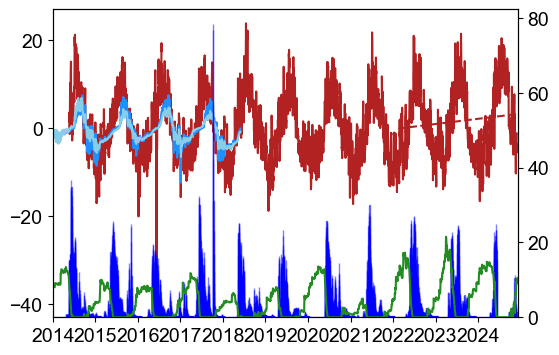

In [672]:
# changing trend in seasons?

fig, ax = plt.subplots(figsize=(6,4))

import statsmodels.api as sm

time = '2014-01-01'
temp_sub = jtt_temp.copy()
temp_sub = temp_sub.resample('1d').median()
temp_sub = temp_sub[temp_sub.index > time] 
ST_sub = ST_sub[ST_sub.index > time]

ax.plot(temp_sub.index, temp_sub['temperature'], color='firebrick', label='Air temperature')
ax.plot(ST_sub.index,ST_sub['ST2'], color='dodgerblue', label='BS air temperature')
ax.plot(ST_sub.index,ST_sub['ST3'], color='skyblue', label='BS rock temperature')

surfacerunoff_sub =   surfacerunoff_sub[surfacerunoff_sub.index > time]
jtt_xgeo_snow_sub = jtt_xgeo_snow[jtt_xgeo_snow.index > time]

ax_y1 = ax.twinx()
ax_y1.bar(dates.date2num(surfacerunoff_sub.index), surfacerunoff_sub['surfacerunoff'], width = width, ec='blue', color='blue', label='Surface runoff (mm)', alpha=0.5)
ax_y1.plot(jtt_xgeo_snow_sub.index,jtt_xgeo_snow_sub['depth']/10, color='forestgreen', label='Snow depth (dm)')

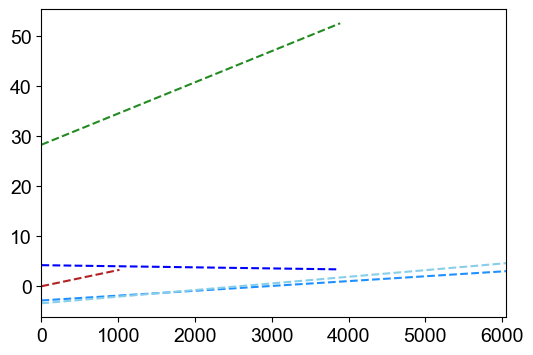

In [674]:
fig, ax = plt.subplots(figsize=(6,4))

data = temp_sub.copy()
data = data.dropna().reset_index()
X = sm.add_constant(np.arange(len(data)))  # Adds a constant term to the predictor
y = data['temperature']
model = sm.OLS(y, X).fit()
data['Predicted'] = model.predict(X)
ax.plot(data['Predicted'], label='Fitted', linestyle='--', color='firebrick')

data = ST_sub.copy()
data = data.dropna().reset_index()
X = sm.add_constant(np.arange(len(data)))  # Adds a constant term to the predictor
y = data['ST2']
model = sm.OLS(y, X).fit()
data['Predicted'] = model.predict(X)
ax.plot(data['Predicted'], label='Fitted', linestyle='--', color='dodgerblue')

data = ST_sub.copy()
data = data.dropna().reset_index()
X = sm.add_constant(np.arange(len(data)))  # Adds a constant term to the predictor
y = data['ST3']
model = sm.OLS(y, X).fit()
data['Predicted'] = model.predict(X)
ax.plot(data['Predicted'], label='Fitted', linestyle='--', color='skyblue')

data = surfacerunoff_sub.copy()
data = data.dropna().reset_index()
X = sm.add_constant(np.arange(len(data)))  # Adds a constant term to the predictor
y = data['surfacerunoff']
model = sm.OLS(y, X).fit()
data['Predicted'] = model.predict(X)
ax.plot(data['Predicted'], label='Fitted', linestyle='--', color='blue')

data = jtt_xgeo_snow_sub.copy()
data = data.dropna().reset_index()
X = sm.add_constant(np.arange(len(data)))  # Adds a constant term to the predictor
y = data['depth']
model = sm.OLS(y, X).fit()
data['Predicted'] = model.predict(X)
ax.plot(data['Predicted'], label='Fitted', linestyle='--', color='forestgreen')

In [678]:
temp_sub.head()

,temperature,precip,year,month,day
datetime,,,,,
2014-05-22,1.580,NaN,2014.0,5.0,22.0
2014-05-23,3.640,NaN,2014.0,5.0,23.0
2014-05-24,2.270,NaN,2014.0,5.0,24.0
2014-05-25,-1.285,NaN,2014.0,5.0,25.0
2014-05-26,-0.130,NaN,2014.0,5.0,26.0


In [680]:
data.head()

,datetime,depth,year,month,day,Predicted
0,2014-01-01 06:00:00,82.7,2014,1,1,28.296368
1,2014-01-02 06:00:00,82.2,2014,1,2,28.302615
2,2014-01-03 06:00:00,81.6,2014,1,3,28.308862
3,2014-01-04 06:00:00,81.0,2014,1,4,28.315110
4,2014-01-05 06:00:00,82.6,2014,1,5,28.321357


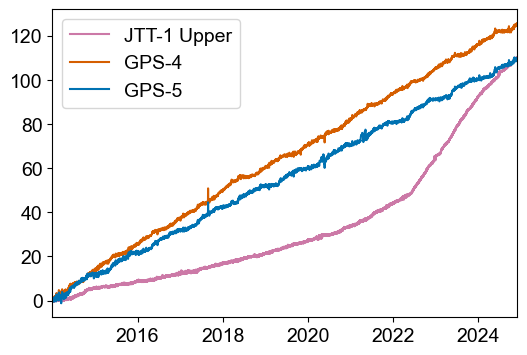

In [611]:
fig, ax = plt.subplots(figsize=(6,4))

time = '2014-01-01'

x = JTT1Disp.iloc[:,0]
# x = JTT2DispUpperZone.iloc[:,0]
y = jett_gps4.iloc[:,3]
# z = jett_gps2.iloc[:,3]
z = jett_gps5.iloc[:,3]

x = x[x.index > time]
y = y[y.index > time]
z = z[z.index > time]

x = x - x[0] 
y = y - y[0]
z = z - z[0]

ax.plot(x.index, x.values, color=colors[0], label='JTT-1 Upper')
ax.plot(y.index, y.values, color=colors[1], label='GPS-4')
ax.plot(z.index, z.values, color=colors[2], label='GPS-5')
# ax.plot(z.index, z.values, color=colors[1], label='GPS-2')
# ax.plot(y.index, y.values, color=colors[2], label='GPS-3')

plt.legend()

ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

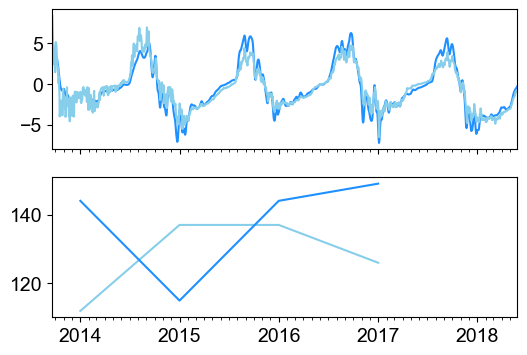

In [586]:
from scipy.signal import savgol_filter
def clean_filt(file, col=0): # colnmbr is the column chosen to filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order) # savitzky-golay filter
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file

# median filter window
window_median = 15 # 7 might be okay and 29 is smooth, tried with 15 as a middle way to keep temp stationary

# rolling mean filter window
window_mean = 7 # 7 is enough to keep temp stationary

# savgol parameters
window_size = 11
poly_order = 3


interval = '1D' # choose between 1D, 1W, 1M


# cleaned data
def clean_df(df,start_time,end_time, interval):
    df = df[df.index.slice_indexer(start_time,end_time)]
    for i, col in enumerate(df.columns):
        df.loc[:,col] = clean_filt(df.loc[:,col]).values # filtered data
        # df.loc[:,col] = medfilt(df.loc[:,col], window_median) # median filter
        df.loc[:, col] = df.loc[:, col].rolling(window=window_mean, center=True).mean() # rolling mean
        df = df.resample(interval).median() # downsampling with median value after cleaning
        df.dropna(inplace=True)
    return df

df = ST.iloc[:,0:2]
df.dropna(inplace=True)
df = clean_df(df, df.index[0],ST.index[-1], interval)

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax1.plot(df.index,df['ST2'], color='dodgerblue', label='BS air temperature')
ax1.plot(df.index,df['ST3'], color='skyblue', label='BS rock temperature')
df = ST.copy()
df = df.resample('D').mean()
df = df[df['ST2'] > 0].groupby('year').size()
df = df[df.index > 2013]
df.index = pd.to_datetime(df.index, format='%Y')
ax2.plot(df.index,df.values, color='skyblue', label='BS rock temperature')
df = ST.copy()
df = df.resample('D').mean()
df = df[df['ST3'] > 0].groupby('year').size()
df = df[df.index > 2013]
df.index = pd.to_datetime(df.index, format='%Y')
ax2.plot(df.index,df.values, color='dodgerblue', label='BS air temperature')
# plt.legend()

# ax.axhline(y=df['ST2'].max(), color='black', linestyle='--')
# ax.axhline(y=df['ST2'].min(), color='black', linestyle='--')
# ax.axhline(y=df['ST3'].max(), color='gray', linestyle='--')
# ax.axhline(y=df['ST3'].min(), color='gray', linestyle='--')

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # -%m-%d
ax1.xaxis.set_minor_locator(mdates.MonthLocator())


In [26]:
JT_CLM_1_2.head()

,TJ_10: JT_CLM_002,TJ_5: JT_CLM_001_002,year,month,day
datetime,,,,,
2007-10-09 13:00:00,NaN,-0.6,2007,10,9
2007-10-09 14:00:00,NaN,-0.6,2007,10,9
2007-10-09 15:00:00,NaN,-0.6,2007,10,9
2007-10-09 16:00:00,NaN,-0.6,2007,10,9
2007-10-09 17:00:00,NaN,-0.6,2007,10,9


([<matplotlib.axis.XTick at 0x2a4cca22410>,
 [Text(18993.0, 0, '2022-01-01'),
  Text(19358.0, 0, '2023-01-01'),
  Text(19723.0, 0, '2024-01-01')])

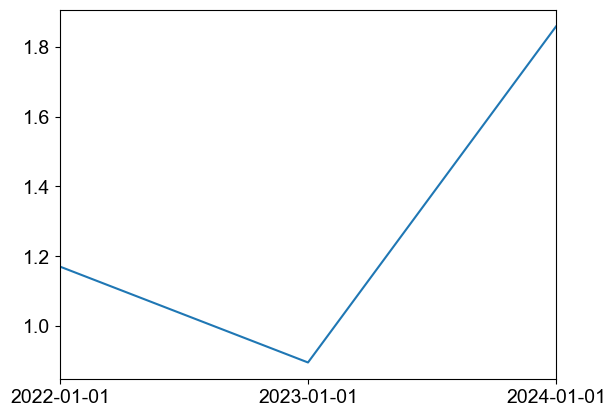

In [127]:
# JT_CLM_1_2.iloc[:,1].plot()
test = JT_CLM_1_2.iloc[:,1:3].copy()
test = test.loc[test['year'] > 2021]
# test.iloc[:,0].plot()

df = JT_CLM_1_2.copy()
df = df.resample('D').mean() # mean is probably best to capture the variation and find out if it is relativley colder or warmer years
# permafrost index
days_above_zero = df[df.iloc[:,1] > 0].groupby('year').size()
days_below_zero = df[df.iloc[:,1] < 0].groupby('year').size()
# Ensure all years are represented (fill missing years with 0)
all_years = pd.DataFrame({'year': df['year'].unique()})
days_above_zero = all_years.merge(days_above_zero.rename('days_above_zero'), on='year', how='left').fillna(0)
days_below_zero = all_years.merge(days_below_zero.rename('days_below_zero'), on='year', how='left').fillna(0)
# Merge the counts
yearly_counts = pd.merge(days_above_zero, days_below_zero, on='year')
# Calculate permafrost index (days_above_zero / days_below_zero)
yearly_counts['freeze_index'] = yearly_counts['days_above_zero'] / (
    yearly_counts['days_below_zero'] + np.finfo(float).eps  # Avoid division by zero
)
days_freeze_year = yearly_counts.loc[yearly_counts['year'] > 2021]

days_freeze_year.loc[:,'year'] = pd.to_datetime(days_freeze_year['year'], format='%Y')
plt.plot(days_freeze_year.iloc[:,0], days_freeze_year.iloc[:,3])
plt.xlim(pd.Timestamp('2022-01-01'),pd.Timestamp('2024-01-01'))
plt.xticks(days_freeze_year.iloc[:,0])

<Axes: >

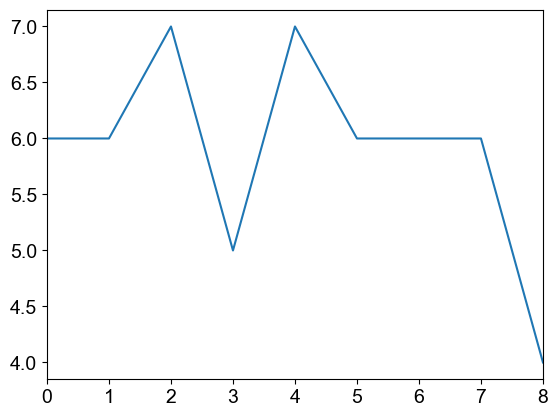

In [201]:
# df = jtt_temp.copy()
# df = gam_temp.copy()
# df = gam_xgeo_temp.copy()
df = jtt_temp_GST.copy()

# set time so that the index is an entire year and representative
start_time = pd.Timestamp('2015-01-01')
end_time = pd.Timestamp('2023-12-31')

df = df.set_index('Date')
df =  df[df.index.slice_indexer(start_time,end_time)]
# df = df.resample('D').mean()

# Ensure the temperature column is correctly indexed
temperature_column = 'temperature'

# Extract year and month from the DateTime index
df['year'] = df.index.year
df['month'] = df.index.month

# Permafrost index
# Group by year and month
days_above_zero_monthly = df[df[temperature_column] > 0].groupby(['year', 'month']).size().reset_index(name='days_above_zero')
days_below_zero_monthly = df[df[temperature_column] < 0].groupby(['year', 'month']).size().reset_index(name='days_below_zero')

# Group by year only
days_above_zero_yearly = df[df[temperature_column] > 0].groupby(['year']).size().reset_index(name='days_above_zero')
days_below_zero_yearly = df[df[temperature_column] < 0].groupby(['year']).size().reset_index(name='days_below_zero')


# # Choose whether to use monthly or yearly data
use_monthly = False # off
# use_monthly = True  # on 

if use_monthly:
    # Merge the monthly DataFrames
    merged_df = pd.merge(days_above_zero_monthly, days_below_zero_monthly, on=['year', 'month'], how='outer').fillna(0)
    # Create a 'date' column from 'year' and 'month'
    merged_df['date'] = pd.to_datetime(merged_df[['year', 'month']].assign(day=1))
    # Set the 'date' column as the index
    merged_df.set_index('date', inplace=True)
    # Drop the now redundant 'year' and 'month' columns
    merged_df.drop(columns=['year', 'month'], inplace=True)
else:
    # Merge the yearly DataFrames
    merged_df = pd.merge(days_above_zero_yearly, days_below_zero_yearly, on=['year'], how='outer').fillna(0)
    # Create a 'date' column from 'year'
    merged_df['date'] = pd.to_datetime(merged_df['year'].astype(str) + '-01-01')
    # Set the 'date' column as the index
    merged_df.set_index('date', inplace=True)
    # Drop the now redundant 'year' column
    merged_df.drop(columns=['year'], inplace=True)

# Create the freeze index column
merged_df['freeze_index'] = merged_df['days_above_zero'] / (merged_df['days_below_zero'] + np.finfo(float).eps) # np.finfo(float).eps very smal value added to avoid dividing on zero

# Separate into warm and cold columns
merged_df['warm'] = merged_df['freeze_index'].apply(lambda x: x if x > 1 else np.nan)
merged_df['cold'] = merged_df['freeze_index'].apply(lambda x: x if x <= 1 else np.nan)

# Normalize warm and cold columns from 0 to 1
file = merged_df['warm']
merged_df['warm'] = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file = merged_df['cold']
merged_df['cold'] = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))

# quick fix for plotting
merged_df = merged_df.reset_index()
merged_df['year'] = merged_df['date'].dt.year

jett_freeze_index = merged_df.copy()
# gam_freeze_index = merged_df.copy()
# plt.scatter(freeze_index.index, freeze_index['warm'], color=colors[1], label='Freeze index')
# plt.scatter(freeze_index.index, freeze_index['cold'], color=colors[2], label='Freeze index')

jett_freeze_index.iloc[:,2].plot()

<Axes: >

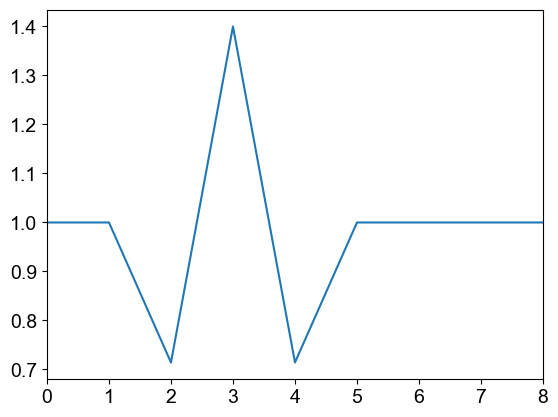

In [209]:
jett_freeze_index.iloc[:,3].plot()

In [193]:
path = 'Juditha_permafrost\\'  # set folder related to script location
# jtt_temp_G45 = pd.read_csv(path + 'All_scenarios_longterm_45m.csv', sep='\t', parse_dates=['datetime']) # Temp
jtt_temp_GST = pd.read_csv(path + 'RUN1_monthly_GST_2000_2023.txt', sep='\t') # Autoparser fucked up the df...
jtt_temp_GST['Date'] = pd.to_datetime(jtt_temp_GST.loc[:,'Date'], format='%d.%m.%Y')
jtt_temp_GST = jtt_temp_GST.rename(columns={'Value': 'temperature'})
df = jtt_temp_GST.copy()
df['year'] = df['Date'].dt.year
df = df.groupby('year')['temperature'].agg(['mean', 'max']).reset_index()
yearly_GST = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]
yearly_GST.head()

,year,mean,max
16,2015,1.257500,11.60
17,2016,1.924167,11.23
18,2017,1.290000,10.13
19,2018,1.290000,14.79
20,2019,2.093333,11.11


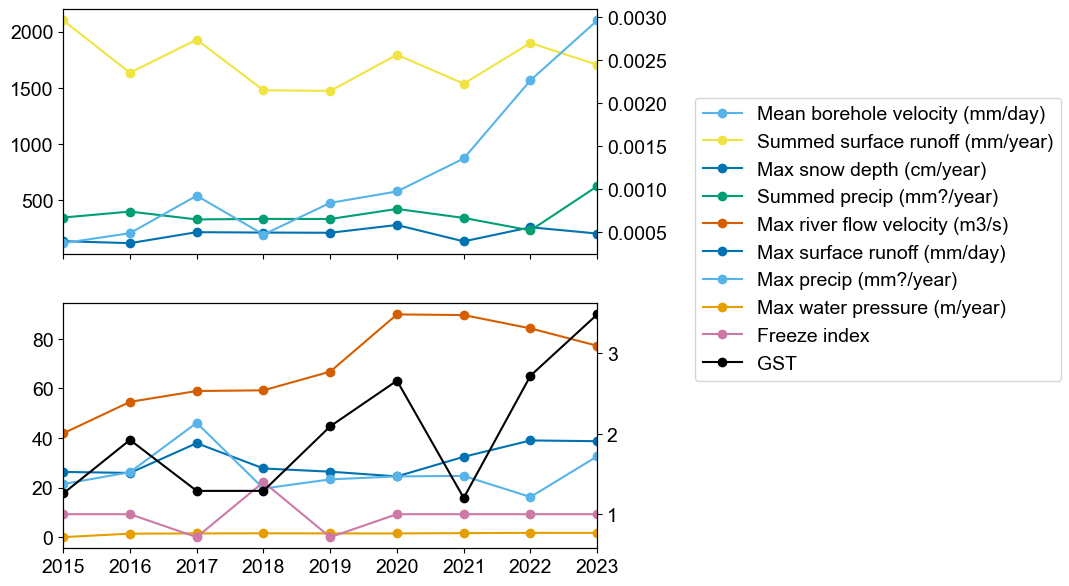

In [211]:
# Get velocity in a different way than before with linear fit
def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference
    
# add to plot.
# velocity of borehole
# rate of temperature change
# rate of snowmelt, could be river flow as proxy

path = 'Juditha_permafrost\\'  # set folder related to script location
# jtt_temp_G45 = pd.read_csv(path + 'All_scenarios_longterm_45m.csv', sep='\t', parse_dates=['datetime']) # Temp
jtt_temp_GST = pd.read_csv(path + 'RUN1_monthly_GST_2000_2023.txt', sep='\t') # Autoparser fucked up the df...
jtt_temp_GST['Date'] = pd.to_datetime(jtt_temp_GST.loc[:,'Date'], format='%d.%m.%Y')
df = jtt_temp_GST.copy()
df['year'] = df['Date'].dt.year
df = df.groupby('year')['Value'].agg(['mean', 'max']).reset_index()
yearly_GST = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]

df = jtt_precip.copy()
df = df.resample('D').sum()
df = df.reset_index()
df['year'] = df['datetime'].dt.year
df = df.groupby('year')['precip'].agg(['mean', 'max', 'sum']).reset_index()
yearly_precip = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]

df = JTT1Disp.iloc[:,0]
df = df.reset_index()
df['year'] = df['Date:'].dt.year
df.iloc[:,1] = diff_shift(df.iloc[:,1],1) # adding velocity
df = df.groupby('year')['Disp_summed [mm]:'].agg(['mean', 'max']).reset_index()
yearly_vel = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]

df = JTT1Wp.iloc[:,0]
df = df.reset_index()
df['year'] = df['Date:'].dt.year
df = df.groupby('year')['Mod4_Water pressure [m]:'].agg(['mean', 'max']).reset_index()
yearly_wp = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]

df = jtt_gps5.iloc[:,3]
df = df.reset_index()
df['year'] = df['time'].dt.year
df.iloc[:,1] = diff_shift(df.iloc[:,1],1) # adding velocity
df = df.groupby('year')['2d'].agg(['mean', 'max']).reset_index()
yearly_vel_gps5 = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]

df = jtt_gps4.iloc[:,3]
df = df.reset_index()
df['year'] = df['time'].dt.year
df.iloc[:,1] = diff_shift(df.iloc[:,1],1) # adding velocity
df = df.groupby('year')['2d'].agg(['mean', 'max']).reset_index()
yearly_vel_gps4 = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]

df = river1.copy() 
df = df.reset_index()
df['year'] = df['datetime'].dt.year
df = df.groupby('year')['Vannføring (m³/s)'].agg(['mean', 'max']).reset_index()
yearly_wflow = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]

df = jtt_xgeo_surfacerunnoff.copy()
df = df.reset_index()
df['year'] = df['datetime'].dt.year
df = df.groupby('year')['surfacerunoff'].agg(['mean', 'max', 'sum']).reset_index()
yearly_runoff = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]

df = jtt_xgeo_snow.copy()
df = df.reset_index()
df['year'] = df['datetime'].dt.year
# df.iloc[:,1] = diff_shift(df.iloc[:,1],1) # adding velocity
df = df.groupby('year')['depth'].agg(['mean', 'max', 'sum']).reset_index()
yearly_snow = df.loc[(df['year'] >= 2015) & (df['year'] <= 2023)]

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,7))
ax2.plot(yearly_wflow.iloc[:,0].values, yearly_wflow.iloc[:,2].values, marker='o', color=colors[1], label='Max river flow velocity (m3/s)')
ax2.plot(yearly_runoff.iloc[:,0].values, yearly_runoff.iloc[:,2].values, marker='o', color=colors[2], label='Max surface runoff (mm/day)')

ax2.plot(yearly_precip.iloc[:,0].values, yearly_precip.iloc[:,2].values, marker='o', color=colors[5], label='Max precip (mm?/year)')
ax2.plot(yearly_wp.iloc[:,0].values, yearly_wp.iloc[:,2].values, marker='o', color=colors[6], label='Max water pressure (m/year)')
ax_y2 = ax2.twinx()
ax_y2.plot(jett_freeze_index.iloc[:,-1], jett_freeze_index.iloc[:,3], marker='o', color=colors[0], label='Freeze index')
ax_y2.plot(yearly_GST.iloc[:,0], yearly_GST.iloc[:,1], marker='o', color=colors[7], label='GST')

ax1.plot(yearly_runoff.iloc[:,0].values, yearly_runoff.iloc[:,3].values, marker='o', color=colors[3], label='Summed surface runoff (mm/year)')
ax1.plot(yearly_snow.iloc[:,0].values, yearly_snow.iloc[:,2].values, marker='o', color=colors[2], label='Max snow depth (cm/year)')
ax1.plot(yearly_precip.iloc[:,0].values, yearly_precip.iloc[:,3].values, marker='o', color=colors[4], label='Summed precip (mm?/year)')
ax_y1 = ax1.twinx()
ax_y1.plot(yearly_vel.iloc[:,0].values, yearly_vel.iloc[:,1].values, marker='o', color=colors[5], label='Mean borehole velocity (mm/day)')
# ax_y1.plot(yearly_vel_gps4.iloc[:,0].values, yearly_vel_gps4.iloc[:,1].values, marker='o', color=colors[6], label='Mean gps4 velocity (mm/day)')
# ax_y1.plot(yearly_vel_gps5.iloc[:,0].values, yearly_vel_gps5.iloc[:,1].values, marker='o', color=colors[7], label='Mean gps5 velocity (mm/day)')

# ax[0].set_ylabel('Days above 0 degrees')

lines, labels = ax2.get_legend_handles_labels()
lines4, labels4 = ax_y2.get_legend_handles_labels()
lines3, labels3 = ax1.get_legend_handles_labels()
lines2, labels2 = ax_y1.get_legend_handles_labels()
fig.subplots_adjust(right=0.57) 
leg = fig.legend(lines2+lines3+lines+lines4, labels2+labels3+labels+labels4, loc = (0.65, 0.35), ncol=1) # center of fig

ax1.set_xticks(yearly_wflow.iloc[:,0])
# ax1.set_xlim(2015,2023)

In [213]:
import pandas as pd
import numpy as np
df = pd.DataFrame({
    'bh velocity': yearly_vel.iloc[:,1].values,
    'precip summed': yearly_precip.iloc[:,3].values,
    'river velocity': yearly_wflow.iloc[:,2].values,
    'runoff max': yearly_runoff.iloc[:,2].values,
    'runoff summed': yearly_runoff.iloc[:,3].values,
    'snowdepth': yearly_snow.iloc[:,2].values,
    'precip max': yearly_precip.iloc[:,2].values,
    'freeze index': jett_freeze_index.iloc[:,3].values,
    'GST': yearly_GST.iloc[:,1].values
})

df = df.dropna()
# df = pd.concat([days_above_zero_per_year.values, yearly_vel.iloc[:,1].values, yearly_wflow.iloc[:,2].values, yearly_runoff.iloc[:,2].values, yearly_runoff.iloc[:,3].values, yearly_snow.iloc[:,2].values], axis=0)
# df.columns = ['Days above zero', 'bh velocity', 'river velocity', 'runoff max', 'runoff summed', 'snowdepth']
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,bh velocity,precip summed,river velocity,runoff max,runoff summed,snowdepth,precip max,freeze index,GST
bh velocity,nan,nan,nan,nan,nan,nan,nan,nan,nan
precip summed,0.44,nan,nan,nan,nan,nan,nan,nan,nan
river velocity,0.61,0.11,nan,nan,nan,nan,nan,nan,nan
runoff max,0.78,0.08,0.31,nan,nan,nan,nan,nan,nan
runoff summed,0.05,-0.12,-0.26,0.24,nan,nan,nan,nan,nan
snowdepth,0.34,-0.07,0.50,0.23,0.09,nan,nan,nan,nan
precip max,0.08,0.35,-0.14,0.41,0.19,-0.03,nan,nan,nan
freeze index,-0.08,0.05,-0.01,-0.20,-0.24,-0.03,-0.54,nan,nan
GST,0.77,0.57,0.50,0.32,0.02,0.51,-0.07,-0.08,nan


In [414]:
days_above_zero_per_year.index

Index([2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0, 2024.0], dtype='float64', name='year')

(2013.0, 2024.0)

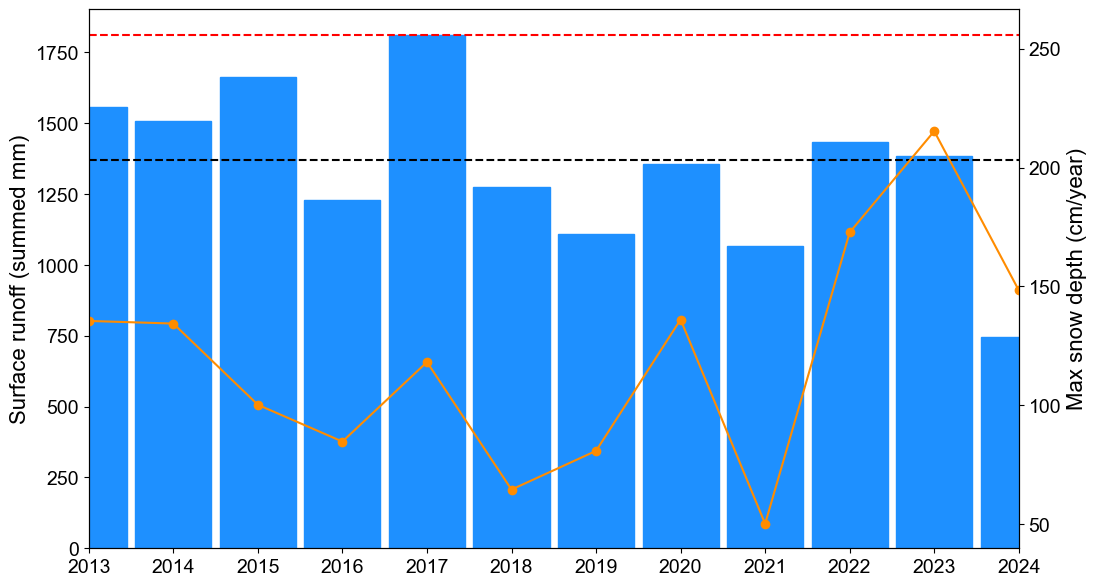

In [337]:
df = xgeo_surfacerunoff.copy()
df = df.reset_index()
df['year'] = df['datetime'].dt.year
df = df.loc[df['year'] >= 2013]
yearly_runoff = df.groupby('year')['surfacerunoff'].agg(['mean', 'max', 'sum']).reset_index()

# dates.date2num(
width = .9
fig, ax = plt.subplots(figsize=(12,7))
# ax.plot(yearly_runoff.iloc[:,0].values, yearly_runoff.iloc[:,3].values, marker='o', color='r', label='Summed surface runoff (mm/year)')
ax.bar(yearly_runoff['year'], yearly_runoff['sum'], width = width, ec='dodgerblue', color='dodgerblue')
ax.axhline(y=yearly_runoff['sum'].median(), color='k', linestyle='--')
ax.axhline(y=yearly_runoff['sum'].max(), color='r', linestyle='--')

ax.set_ylabel('Surface runoff (summed mm)')

ax_y1 = ax.twinx()
ax_y1.plot(yearly_snow.iloc[:,0].values, yearly_snow.iloc[:,2].values, marker='o', color='darkorange', label='Max snow depth (cm/year)')
ax_y1.set_ylabel('Max snow depth (cm/year)')
ax.set_xticks(yearly_runoff.iloc[:,0])
plt.xlim(2013, 2024)

In [18]:
from scipy.signal import savgol_filter
def clean_filt(file, col=0): # colnmbr is the column chosen to filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order) # savitzky-golay filter
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file

# median filter window
window_median = 15 # 7 might be okay and 29 is smooth, tried with 15 as a middle way to keep temp stationary

# rolling mean filter window
window_mean = 7 # 7 is enough to keep temp stationary

# savgol parameters
window_size = 11
poly_order = 3

#### After rock temp  #####
start_time = pd.Timestamp('2018-01-01') # need as long as possible to make stationary, 2015 to 2018 is not enough
end_time = pd.Timestamp('2024-01-01')

interval = '1D' # choose between 1D, 1W, 1M

# original data
x = JTT1Disp.iloc[:,0] # hourly data intervals
y = JTT1Wp.iloc[:,0] # hourly data intervals
z = jtt_xgeo_temp.iloc[:,0] # daily data intervals   
f = river1.iloc[:,0] # 30 min data intervals

df = pd.concat([x,y,z,f], axis=1)
df.columns =['Disp', 'WP', 'Temp', 'River']
df.dropna(inplace=True)
file = df.copy()
file = file[file.index.slice_indexer(start_time,end_time)] # slicing
file = file.resample(interval).median() # downsampling with median value
original_df = df.copy()

# cleaned data
def clean_df(df,start_time,end_time, interval):
    df = df[df.index.slice_indexer(start_time,end_time)]
    for i, col in enumerate(df.columns):
        df.loc[:,col] = clean_filt(df.loc[:,col]).values # filtered data
        # df.loc[:,col] = medfilt(df.loc[:,col], window_median) # median filter
        df.loc[:, col] = df.loc[:, col].rolling(window=window_mean, center=True).mean() # rolling mean
        df = df.resample(interval).median() # downsampling with median value after cleaning
        df.dropna(inplace=True)
    return df

df = clean_df(df, start_time,end_time, interval)
df.head()

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfu

,Disp,WP,Temp,River
2018-01-13,24.181140,0.0,-2.199351,0.91951
2018-01-14,24.186917,0.0,-3.130969,0.887072
2018-01-15,24.186144,0.0,-4.539660,0.8559
2018-01-16,24.183312,0.0,-6.223044,0.825773
2018-01-17,24.169519,0.0,-7.897736,0.796657


<Axes: >

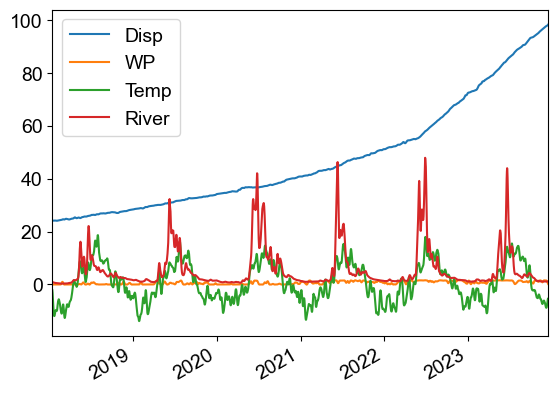

In [20]:
df.plot()

### Cleaning data and trying to model

In [7]:
path = 'Juditha_permafrost\\'  # set folder related to script location
# jtt_temp_G45 = pd.read_csv(path + 'All_scenarios_longterm_45m.csv', sep='\t', parse_dates=['datetime']) # Temp
jtt_temp_GST = pd.read_csv(path + 'All_scenarios_weekly_GST_percentiles.txt', sep='\t') # Autoparser fucked up the df...
jtt_temp_GST['Date'] = pd.to_datetime(jtt_temp_GST.loc[:,'Date'], format='%d.%m.%Y')
jtt_temp_GST = jtt_temp_GST.set_index('Date')
# jtt_temp_GST.index = pd.to_datetime(jtt_temp_GST.index) + pd.offsets.MonthEnd(0) # for monthly data to make similar as dfs below
# jtt_temp_GST.head()

C:\Users\andregas\AppData\Local\Temp\ipykernel_21820\3915792372.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')


<Axes: >

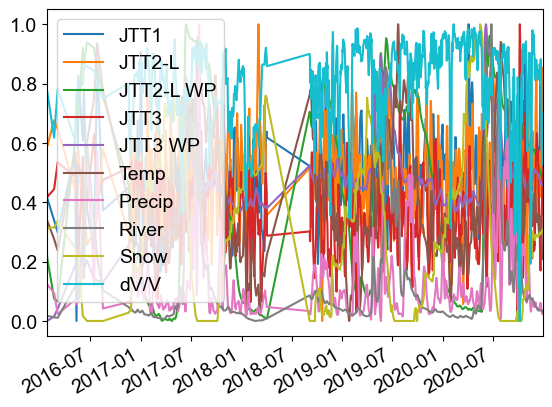

In [33]:
# differencing n rows to get seasonal and trend removed to obtain statinarity
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

def norm(series):
    series = scaler.fit_transform(series.values.reshape(-1, 1)) # transform to normalized values
    # df = scaler.inverse_transform(df) # transform back to original
    return series.reshape(-1) # transform back to correct shape

def clean_filt(file, col=0): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    # file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order) # savitzky-golay filter
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file

# cleaned data
def clean_df(df,start_time,end_time, interval):
    df = df[df.index.slice_indexer(start_time,end_time)]
    for i, col in enumerate(df.columns):
        df.loc[:,col] = clean_filt(df.loc[:,col]).values # filtered data
        # df.loc[:,col] = medfilt(df.loc[:,col], window_median) # median filter
        df.loc[:, col] = df.loc[:, col].rolling(window=window_mean, center=True).mean() # rolling mean
    return df

# values for the butterworth filter
n = 3 # number of days cut off
fs = 1 # sample rate in hours 
cutoff = 1/(24*n) # 1/24 means cutoff at 1 day, but times nyquist frequncey so twice
order = 2 # line from 1 to 0, second order is perfect function

# median filter window
window_median = 15 # 7 might be okay and 29 is smooth, tried with 15 as a middle way to keep temp stationary

# rolling mean filter window
window_mean = 7 # 7 is enough to keep temp stationary

# savgol parameters
window_size = 11
poly_order = 3


#### time window  #####
start_time = pd.Timestamp('2015-01-01') # need as long as possible to make stationary, 2015 to 2018 is not enough
end_time = pd.Timestamp('2021-01-01')

interval = '1D' # choose between 1D, 1W, 1M

# # Freeze index
# freeze_ind = freeze_index(jtt_temp, interval=interval) # create this outside as it is grouping

############## original data resampled to daily to get identical interval and before cleaning so dependent on cleaning parameters as well #########
### boreholes
a = JTT1Disp.iloc[:,0].resample('1D').median() # hourly data intervals

b = JTT2DispLowerZone.iloc[:,0].resample('1D').median() # hourly data intervals
c = JTT2WpLowerZone.iloc[:,0].resample('1D').median() # hourly data intervals

d = JTT3Disp.iloc[:,0].resample('1D').median() # hourly data interval
e = JTT3Wp.iloc[:,0].resample('1D').median() # hourly data intervals

### met var
# z = jtt_xgeo_temp.iloc[:,0] # daily data intervals   
f = jtt_temp.iloc[:,0].resample('1D').median() # hourly data intervals  # This did not work due to duplicate index (multiple identical timestamps)
g = jtt_precip.iloc[:,0].resample('1D').sum() # hourly data intervals
h = river1.iloc[:,0].resample('1D').median() # 30 min data intervals
i = jtt_xgeo_snow.iloc[:,0].resample('1D').median()

columns=['JTT1', 'JTT2-L', 'JTT2-L WP', 'JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River','Snow']
df = pd.concat([a,b,c,d,e,f,g,h,i], axis=1)
df.columns=columns
df = df.dropna()
#####################################################################################################################

# Using file data in the final plot of the model
file = df.copy()
file = file[file.index.slice_indexer(start_time,end_time)] # slicing
a = file.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
a = diff_shift(a, 1) # velocity by differencing one row
b = file.iloc[:,1].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
b = diff_shift(b, 1) # velocity by differencing one row
c = file.iloc[:,2].resample(interval).mean() # WP
d = file.iloc[:,3].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
d = diff_shift(d, 1) # velocity by differencing one row
e = file.iloc[:,4].resample(interval).mean() # WP
f = file.iloc[:,5].resample(interval).mean() # Temp
g = file.iloc[:,6].resample(interval).sum() # Precip
h = file.iloc[:,7].resample(interval).mean() # River 
i = file.iloc[:,8].resample(interval).mean() # Snow 

file = pd.concat([a,b,c,d,e,f,g,h,i], axis=1)
file.columns=columns
file = file.dropna()

original_df = df.copy()
df = clean_df(original_df,start_time,end_time, interval)
a = df.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
a = diff_shift(a, 1) # velocity by differencing one row
b = df.iloc[:,1].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
b = diff_shift(b, 1) # velocity by differencing one row
c = df.iloc[:,2].resample(interval).mean() # WP
d = df.iloc[:,3].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
d = diff_shift(d, 1) # velocity by differencing one row
e = df.iloc[:,4].resample(interval).mean() # WP
f = df.iloc[:,5].resample(interval).mean() # Temp
g = df.iloc[:,6].resample(interval).sum() # Precip
h = df.iloc[:,7].resample(interval).mean() # River 
i = file.iloc[:,8].resample(interval).mean() # Snow 
# j = jtt_temp_GST.iloc[:,2] # Modeled mean GST weekly from 12 model runs
# j = j[j.index.slice_indexer(a.index[0],a.index[-1])]
# j = j.resample(interval).mean() # GST when weekly data
k = seismic.iloc[:,1] # seismic percentage change in velocity (dV/V)
k = k[k.index.slice_indexer(a.index[0],a.index[-1])]

df = pd.concat([a,b,c,d,e,f,g,h,i,k], axis=1)
columns=['JTT1', 'JTT2-L', 'JTT2-L WP', 'JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River','Snow', 'dV/V'] # 'JTT1_GST'
# df = pd.concat([a,b,c,d,e,f,g,h,i], axis=1)
df.columns=columns
df = df.dropna()
# Scale data
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df.plot()

### Corelation matrix

In [35]:
import pandas as pd
import numpy as np
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,JTT1,JTT2-L,JTT2-L WP,JTT3,JTT3 WP,Temp,Precip,River,Snow,dV/V
JTT1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
JTT2-L,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan
JTT2-L WP,0.01,0.05,nan,nan,nan,nan,nan,nan,nan,nan
JTT3,-0.05,-0.05,0.09,nan,nan,nan,nan,nan,nan,nan
JTT3 WP,-0.02,0.12,0.66,-0.07,nan,nan,nan,nan,nan,nan
Temp,-0.02,-0.01,0.75,0.12,0.55,nan,nan,nan,nan,nan
Precip,0.10,0.03,0.35,-0.05,0.16,0.43,nan,nan,nan,nan
River,-0.06,0.09,0.63,0.08,0.73,0.69,0.33,nan,nan,nan
Snow,-0.02,0.02,-0.70,-0.15,-0.14,-0.49,-0.36,-0.22,nan,nan
dV/V,0.06,-0.05,-0.14,-0.16,-0.06,-0.03,0.08,-0.06,0.13,nan


In [49]:
df.head(3)

,JTT1,JTT2-L,JTT2-L WP,JTT3,JTT3 WP,Temp,Precip,River,Snow,dV/V
2016-01-26,0.444548,0.608164,0.226856,0.435322,0.010933,0.342211,0.109532,0.017224,0.286633,0.724244
2016-01-27,0.413633,0.589261,0.212071,0.417860,0.000000,0.337611,0.123108,0.017062,0.313438,0.773106
2016-02-21,0.339152,0.677061,0.075492,0.444387,0.015360,0.275466,0.093983,0.012366,0.315225,0.617448


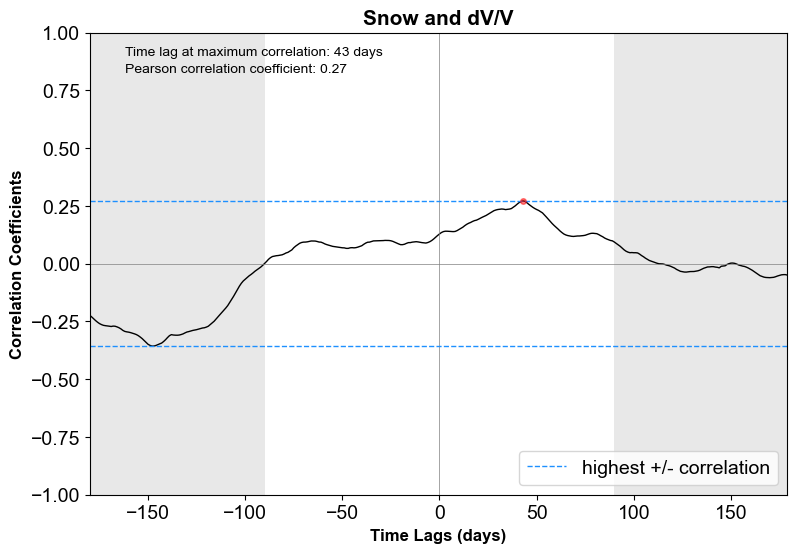

In [57]:
# This method is good. Same outcome as for statsmodels ccf

# Do correlations on stationary variables!
interval = '1D'
crosscorr_lag = 6 # months, tried 3 months did not work, tried 12 months = too much. Try 6 months now and only look at 3 months by graying out the boarders.
correlation_window = 90 # days, allowed window to look at

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,1] #  JTT2-L

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,2] #  JTT2-L WP

# series1 = df.iloc[:,0] # JTT1
# series2 = df.iloc[:,3] #  JTT3

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,4] #  JTT3 WP

# series1 = df.iloc[:,3] #  JTT3
# series2 = df.iloc[:,4] #  JTT3 WP

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,5] #  Temp

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,6] #  Precip

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,7] #  River

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,6] #  Snow

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,9] #  GST

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,9] #  dV/V

series1 = df.iloc[:,8] #  JTT2
series2 = df.iloc[:,9] #  dV/V



# Set the maximum lag you want to consider

#### frequency ####
if interval == '1D':
    h = 1 # per day 
    time_inter = 'days'
if interval == '1W':
    h = 1/7 # per week 
    time_inter = 'weeks'
if interval == '1M':
    h = 1/30 # per month 
    time_inter = 'months'
#######################
n_months = crosscorr_lag
period = int(h*correlation_window) # we assume correlation should happen within 90 days # to make sure it is an integer number
max_lag = int(n_months*30*h) # to make sure it is an integer number
lags = range(-max_lag, max_lag)

# Initialize arrays to store results
correlation_coefficients = []
p_values = []

# Loop through different time lags (both positive and negative)
for lag in lags:
    # Calculate Pearson correlation coefficient and p-value
    if lag < 0:
        correlation_coefficient, p_value = pearsonr(series1[:lag], series2[-lag:])
    elif lag == 0:
        correlation_coefficient, p_value = pearsonr(series1, series2)
    else:
        correlation_coefficient, p_value = pearsonr(series1[lag:], series2[:-lag])
    
    # Append results to arrays
    correlation_coefficients.append(correlation_coefficient)
    p_values.append(p_value)

# # Find the lag with the maximum absolute correlation for entire time series
# max_corr_index = np.argmax(np.abs(correlation_coefficients))
# max_corr_lag = lags[max_corr_index]

# Find the lag with the maximum absolute correlation within +/- 3 months
corr_window = correlation_coefficients[period:period*3]
max_corr_index = np.argmax(np.abs(corr_window))
max_corr_lag = lags[period:period*3][max_corr_index]

n_std = 2
small_size = 10

import scipy.stats as st 
def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf, color='black', lw=1)
    ax.axvline(x = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = np.max(ccf), color = 'dodgerblue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'dodgerblue', lw = 1, linestyle='--')
    ax.plot(max_corr_lag, corr_window[max_corr_index], color='red', marker='o', markersize=4, alpha=0.5) # zorder=0 # point to highlight max within corr_window # point to highlight max within corr_window
    
    # # 2 x std
    # ax.axhline(y = np.mean(ccf)+n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--', label = f'{n_std} x std')
    # ax.axhline(y = np.mean(ccf)-n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--')
    # # # 1 x std
    # # ax.axhline(y = np.mean(ccf)+1*np.std(ccf), color = 'red', lw = 1, linestyle='--', label = f'{1} x std')
    # # ax.axhline(y = np.mean(ccf)-1*np.std(ccf), color = 'red', lw = 1, linestyle='--')
    
    # gray out area
    ax.axvspan(lags_plot[0], -period, facecolor='lightgray', alpha=0.5)
    ax.axvspan(+period,lags_plot[-1], facecolor='lightgray', alpha=0.5)
    
    # text in the plot
    y_pos = lags_plot[0]-(lags_plot[0]*0.1)
    ax.text(y_pos, 0.90, f'Time lag at maximum correlation: {max_corr_lag:.0f} {time_inter}', horizontalalignment='left', color='k', fontsize=small_size)
    ax.text(y_pos, 0.83, f'Pearson correlation coefficient: {corr_window[max_corr_index]:.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    # ax.text(y_pos, 0.76, f'2 x standard deviation: +{np.mean(ccf)+n_std*np.std(ccf):.2f}/{np.mean(ccf)-n_std*np.std(ccf):.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    pval = []
    # if p_values[max_corr_index] < 0.001:
    #     ax.text(y_pos, 0.69, f'P-value: <0.001', horizontalalignment='left', color='k', fontsize=small_size)
    # else:
    #     ax.text(y_pos, 0.69, f'P-value: {p_values[max_corr_index]:.3f}', horizontalalignment='left', color='k', fontsize=small_size)
    
    # cosmetics
    ax.set(ylim = [-1, 1])
    ax.set_title(f'{series1.name} and {series2.name}', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel(f'Time Lags ({time_inter})', weight='bold', fontsize = 12)
    
    plt.legend(loc='lower right')
    
    # # saving
    # path = 'plots\\'
    # save_name = f'{path}crosscorr_{series1.name}_{series2.name}_lag{n_months}.png'
    # fig.savefig(save_name, dpi=300, bbox_inches='tight')
    
# setting size of plotting window
lags_plot = np.linspace(lags[0],lags[-1], num=int(max_lag*2)) # use the interval of df

ccf_plot(lags_plot, correlation_coefficients)

# the first variable (x) is leading if negative lage time, and second variable (y) is leading if positive lag time

### Cleaning again for modeling

In [5]:
path = 'Juditha_permafrost\\'  # set folder related to script location
# jtt_temp_G45 = pd.read_csv(path + 'All_scenarios_longterm_45m.csv', sep='\t', parse_dates=['datetime']) # Temp
jtt_temp_GST = pd.read_csv(path + 'All_scenarios_weekly_GST_percentiles.txt', sep='\t') # Autoparser fucked up the df...
jtt_temp_GST['Date'] = pd.to_datetime(jtt_temp_GST.loc[:,'Date'], format='%d.%m.%Y')
jtt_temp_GST = jtt_temp_GST.set_index('Date')
# jtt_temp_GST.index = pd.to_datetime(jtt_temp_GST.index) + pd.offsets.MonthEnd(0) # for monthly data to make similar as dfs below
# jtt_temp_GST.head()

In [23]:
jtt_temp_GST.tail()

,Min,Q1,Mean,Q3,Max
Date,,,,,
2023-07-30,14.68,14.74,14.85,14.96,15.00
2023-08-06,14.45,14.49,14.59,14.69,14.72
2023-08-13,15.40,15.43,15.58,15.73,15.76
2023-08-20,11.09,11.12,11.21,11.31,11.32
2023-08-27,11.90,11.93,12.01,12.09,12.11


In [7]:
# differencing n rows to get seasonal and trend removed to obtain statinarity
from scipy.signal import savgol_filter

def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

def norm(series):
    series = scaler.fit_transform(series.values.reshape(-1, 1)) # transform to normalized values
    # df = scaler.inverse_transform(df) # transform back to original
    return series.reshape(-1) # transform back to correct shape

def clean_filt(file, col=0): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    # file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order) # savitzky-golay filter
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file

# cleaned data
def clean_df(df,start_time,end_time, interval):
    df = df[df.index.slice_indexer(start_time,end_time)]
    for i, col in enumerate(df.columns):
        df.loc[:,col] = clean_filt(df.loc[:,col]).values # filtered data
        # df.loc[:,col] = medfilt(df.loc[:,col], window_median) # median filter
        df.loc[:, col] = df.loc[:, col].rolling(window=window_mean, center=True).mean() # rolling mean
    return df

#### Actual script ####

# values for the butterworth filter
n = 3 # number of days cut off
fs = 1 # sample rate in hours 
cutoff = 1/(24*n) # 1/24 means cutoff at 1 day, but times nyquist frequncey so twice
order = 2 # line from 1 to 0, second order is perfect function

# median filter window
window_median = 15 # 7 might be okay and 29 is smooth, tried with 15 as a middle way to keep temp stationary

# rolling mean filter window
window_mean = 7 # 7 is enough to keep temp stationary

# savgol parameters
window_size = 11
poly_order = 3

# #### With rock temp  #####
# start_time = pd.Timestamp('2014-01-01') # need as long as possible to make stationary, 2015 to 2018 is not enough
# end_time = pd.Timestamp('2019-01-01')

# interval = '1D' # choose between 1D, 1W, 1M

# # original data
# x = JTT2DispUpperZone.iloc[:,0] # hourly data intervals
# y = JTT2WpUpperZone.iloc[:,0] # hourly data intervals
# z = jtt_xgeo_temp.iloc[:,0] # daily data intervals
# f = ST.iloc[:,0] # hourly data intervals    
# df = pd.concat([x,y,z,f], axis=1)
# df.columns =['Disp', 'WP', 'Temp', 'Rock_temp']
# df.dropna(inplace=True)
# file = df.copy()
# file = file[file.index.slice_indexer(start_time,end_time)] # slicing
# file = file.resample(interval).median() # downsampling with median value
# original_df = df.copy()

#### time window  #####

# # Before increase
# start_time = pd.Timestamp('2017-09-01')
# end_time = pd.Timestamp('2020-09-01')

# # During increase
# start_time = pd.Timestamp('2019-09-01') # need as long as possible to make stationary, 2015 to 2018 is not enough
# end_time = pd.Timestamp('2022-09-01') # for weekly data

# # After increase # this time works with doubble differencing of JTT1 (acceleration)
# start_time = pd.Timestamp('2020-09-01')
# end_time = pd.Timestamp('2024-09-01')

# testing to see how taking the window when acceleration is happening works. 09.04.2025 Everything except JTT1 is stationary!
start_time = pd.Timestamp('2019-09-01')
end_time = pd.Timestamp('2023-09-01')

interval = '1W' # choose between 1D, 1W, 1M

# # Freeze index
# freeze_ind = freeze_index(jtt_temp, interval=interval) # create this outside as it is grouping

############## original data resampled to daily to get identical interval and before cleaning so dependent on cleaning parameters as well #########
### boreholes
a = JTT1Disp.iloc[:,0].resample('1D').mean() # hourly data intervals

b = JTT2DispLowerZone.iloc[:,0].resample('1D').mean() # hourly data intervals
c = JTT2WpLowerZone.iloc[:,0].resample('1D').mean() # hourly data intervals

d = JTT3Disp.iloc[:,0].resample('1D').mean() # hourly data interval
e = JTT3Wp.iloc[:,0].resample('1D').mean() # hourly data intervals

### met var
# z = jtt_xgeo_temp.iloc[:,0] # daily data intervals   
f = jtt_temp.iloc[:,0].resample('1D').mean() # hourly data intervals  # This did not work due to duplicate index (multiple identical timestamps)
g = jtt_precip.iloc[:,0].resample('1D').sum() # hourly data intervals
h = river1.iloc[:,0].resample('1D').mean() # 30 min data intervals
i = seismic.iloc[:,0] # daily data

df = pd.concat([a,b,c,d,e,f,g,h,i], axis=1)
columns=['JTT1', 'JTT2-L', 'JTT2-L WP', 'JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River', 'dv/v']
df.columns=columns
df = df.dropna()
#####################################################################################################################

# Using file data in the final plot of the model
file = df.copy()
file = file[file.index.slice_indexer(start_time,end_time)] # slicing
a = file.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
# a = diff_shift(a, 1) # velocity by differencing one row
b = file.iloc[:,1].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
# b = diff_shift(b, 1) # velocity by differencing one row
c = file.iloc[:,2].resample(interval).mean() # WP
d = file.iloc[:,3].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
# d = diff_shift(d, 1) # velocity by differencing one row
e = file.iloc[:,4].resample(interval).mean() # WP
f = file.iloc[:,5].resample(interval).mean() # Temp
g = file.iloc[:,6].resample(interval).sum() # Precip
h = file.iloc[:,7].resample(interval).mean() # River 
i = file.iloc[:,8].resample(interval).mean() # dv/v
file = pd.concat([a,b,c,d,e,f,g,h,i], axis=1)
file.columns=columns
file = file.dropna()

original_df = df.copy()
df = clean_df(original_df,start_time,end_time, interval)
a = df.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
a = diff_shift(a, 1) # velocity by differencing one row
# a = diff_shift(a, 1) # acceleration by differencing one row
b = df.iloc[:,1].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
b = diff_shift(b, 1) # velocity by differencing one row
# b = diff_shift(b, 1) # acceleration by differencing one row
c = df.iloc[:,2].resample(interval).mean() # WP
d = df.iloc[:,3].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
d = diff_shift(d, 1) # velocity by differencing one row
# d = diff_shift(d, 1) # acceleration by differencing one row
e = df.iloc[:,4].resample(interval).mean() # WP
f = df.iloc[:,5].resample(interval).mean() # Temp
g = df.iloc[:,6].resample(interval).sum() # Precip
h = df.iloc[:,7].resample(interval).mean() # River
i = df.iloc[:,8].resample(interval).mean() # dv/v

j = jtt_temp_GST.iloc[:,2] # Modeled mean GST weekly from 12 model runs
j = j[j.index.slice_indexer(a.index[0],a.index[-1])] # Modeled GST monthly
df = pd.concat([a,b,c,d,e,f,g,h,i,j], axis=1)
columns=['JTT1', 'JTT2-L', 'JTT2-L WP', 'JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River', 'dv/v', 'JTT1_GST']
df.columns=columns
df = df.dropna()

# # incorporating interaction and squared terms to see if it helps (adding non-linearity)
# df['WP_Temp'] = df['WP'] * df['Temp']
# df['WP_squared'] = df['WP'] ** 2
# df = df.dropna()

# # Using file data in the final plot of the model
# file = df.copy()
# file = file[file.index.slice_indexer(start_time,end_time)] # slicing
# x = file.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
# x = diff_shift(x, 1) # differencing disp
# y = file.iloc[:,1].resample(interval).mean() # WP
# z = file.iloc[:,2].resample(interval).mean() # Temp
# e = file.iloc[:,3].resample(interval).sum() # Precip
# f = file.iloc[:,4].resample(interval).mean() # River 
# h = file.iloc[:,5].resample(interval).mean() #  
# g = file.iloc[:,6].resample(interval).mean() #  
# file = pd.concat([x,y,z,e,f,h,g], axis=1)
# file.columns =['Disp', 'WP', 'Temp', 'Precip', 'River', 'WP*Temp','WP**2']
# file = file.dropna()

# original_df = df.copy()
# df = clean_df(original_df,start_time,end_time, interval) # cleaning, not in use currently
# x = df.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
# x = diff_shift(x, 1) # differencing disp
# y = df.iloc[:,1].resample(interval).mean() # WP
# z = df.iloc[:,2].resample(interval).mean() # Temp
# e = df.iloc[:,3].resample(interval).sum() # Precip
# f = df.iloc[:,4].resample(interval).mean() # River 
# h = df.iloc[:,5].resample(interval).mean() #  
# g = df.iloc[:,6].resample(interval).mean() #  
# df = pd.concat([x,y,z,e,f,h,g], axis=1)
# df.columns =['Disp', 'WP', 'Temp', 'Precip', 'River', 'WP*Temp','WP**2']
# df = df.dropna()

df_train = df.copy() # Use intire dataset

# Apply decompose (decompose trend, seasonality, and resudials) to make data stationary
from statsmodels.tsa.seasonal import STL

df_list = []
for i,col in enumerate(df_train.columns):
    df = []
    original = df_train.loc[:,col] # data
    # seasonal decompositoon parameters
    if interval == '1ME':
        seasonal = 13 # can try 7 to 13 from chatgpt, but need to test this to see what is correct
        period = 12 
    if interval == '1W':
        seasonal = 13 # can try 7 to 13 from chatgpt
        period = 52 
    if interval == '1D':
        seasonal = 13 # 7 to 25 from chatgpt
        period = 365 
    decomposed_series = STL(original, seasonal=seasonal, period=period).fit() # for daily should be 13 and 365
    trend = decomposed_series.trend
    seasonal = decomposed_series.seasonal
    residual = decomposed_series.resid
    df = pd.DataFrame({'original':original.values, 'trend': trend.values, 'seasonal':seasonal.values, 'residual':residual.values}, index=df_train.index) 
    df.dropna(inplace=True)
    
    #### Comment this part out when finished looking at what series is stationary  ####
    # correlating?
    print(f'{col}')
    # print(df.corr()) # correlations

    #### testing stationarity ####
    from statsmodels.tsa.stattools import adfuller
    for i, variable in enumerate(df.columns):
        # Perform the ADF test
        result = adfuller(df[variable])

        # Extract and print the p-value from the test result
        p_value = result[1]
        print("p-value:", p_value)

        # Interpret the result
        if p_value <= 0.05: # 0.05 or 0.001
            print(f"The variable {variable} is stationary.\n")
        else:
            print(f"The variable {variable} is not stationary.\n")
###############################

    # # choosing just one year
    # df = df[df.index.slice_indexer(pd.Timestamp('2016-01-01'),pd.Timestamp('2017-01-01'))]

    df_list.append(df)

# without non linear part
col = 'original' # only use the ones that passes ADF test
# df = pd.DataFrame({f'{columns[0]}':df_list[0].loc[:,col], f'{columns[1]}':df_list[1].loc[:,col], f'{columns[2]}':df_list[2].loc[:,col], f'{columns[3]}':df_list[3].loc[:,col], f'{columns[4]}':df_list[4].loc[:,col], f'{columns[5]}':df_list[5].loc[:,col], f'{columns[6]}':df_list[6].loc[:,col], f'{columns[7]}':df_list[7].loc[:,col]})

# with GST
df = pd.DataFrame({f'{columns[0]}':df_list[0].loc[:,col], f'{columns[1]}':df_list[1].loc[:,col], f'{columns[2]}':df_list[2].loc[:,col], f'{columns[3]}':df_list[3].loc[:,col], f'{columns[4]}':df_list[4].loc[:,col], f'{columns[5]}':df_list[5].loc[:,col], f'{columns[6]}':df_list[6].loc[:,col], f'{columns[7]}':df_list[7].loc[:,col], f'{columns[8]}':df_list[8].loc[:,col], f'{columns[9]}':df_list[9].loc[:,col]})


# # If non linear part uncomment this 
# col = 'original' # only use the ones that passes ADF test
# df = pd.DataFrame({f'{columns[0]}':df_list[0].loc[:,col], f'{columns[1]}':df_list[1].loc[:,col], f'{columns[2]}':df_list[2].loc[:,col], f'{columns[3]}':df_list[3].loc[:,col], f'{columns[4]}':df_list[4].loc[:,col], f'{columns[5]}':df_list[5].loc[:,col], f'{columns[6]}':df_list[6].loc[:,col], f'{columns[7]}':df_list[7].loc[:,col]})

C:\Users\andregas\AppData\Local\Temp\ipykernel_21172\3276550109.py:15: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')


JTT1
p-value: 0.5531287248127882
The variable original is not stationary.

p-value: 0.8106569762229232
The variable trend is not stationary.

p-value: 6.114864938233614e-05
The variable seasonal is stationary.

p-value: 9.471260987932752e-10
The variable residual is stationary.

JTT2-L
p-value: 1.3163277601002039e-11
The variable original is stationary.

p-value: 0.0006145798705962535
The variable trend is stationary.

p-value: 5.505534884091382e-06
The variable seasonal is stationary.

p-value: 1.6453765889806797e-16
The variable residual is stationary.

JTT2-L WP
p-value: 0.01393694328716393
The variable original is stationary.

p-value: 0.9533555337847383
The variable trend is not stationary.

p-value: 0.007389476322558569
The variable seasonal is stationary.

p-value: 5.585044012128274e-06
The variable residual is stationary.

JTT3
p-value: 4.620037885773406e-18
The variable original is stationary.

p-value: 0.8476522136421176
The variable trend is not stationary.

p-value: 0.00013

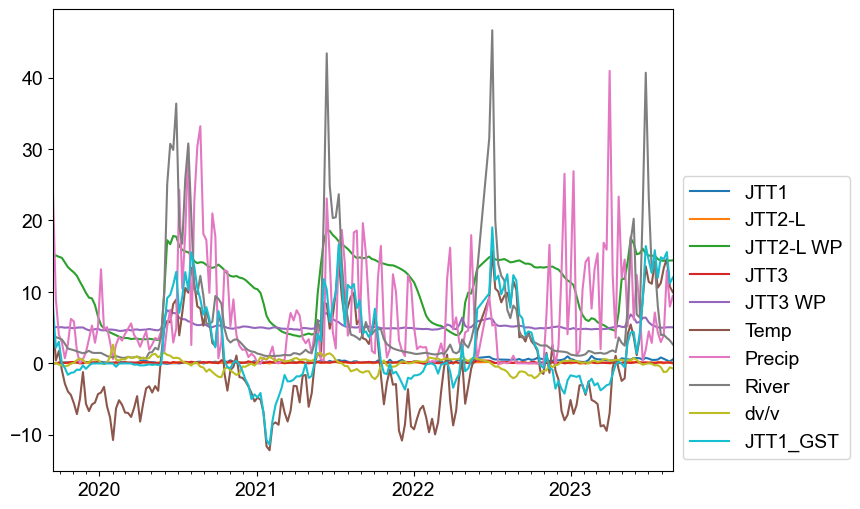

In [9]:
# Plotting scaled dataset
fig, ax = plt.subplots(figsize=(8, 6))
for i,col in enumerate(df.columns):
    ax.plot(df.loc[:,col], label=f'{columns[i]}') # , color=colors[i]

ax.legend(loc='upper left', bbox_to_anchor=(1, 0.66))
# ax.set_ylabel("Scaled from 0 to 1")

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax.xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax.xaxis.set_major_formatter(years_fmt)

# # removing tick labels from the xaxis
# n = 1  # keeps every n row
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

<Axes: >

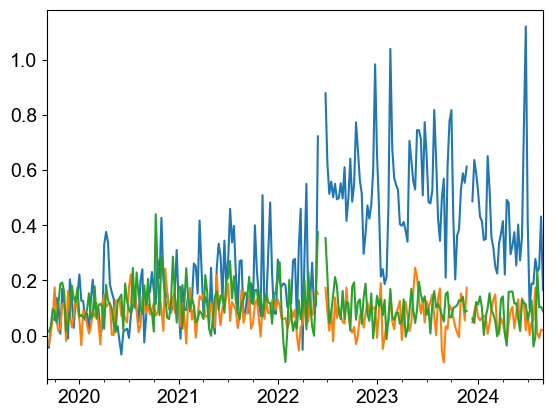

In [38]:
a.plot()
b.plot()
d.plot()

<Axes: >

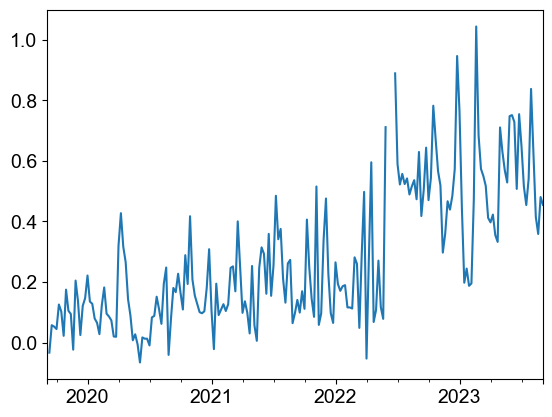

In [39]:
a.plot()

### FFT to see frequencies and periodicity

C:\Users\andregas\AppData\Local\Temp\ipykernel_4640\1226762640.py:40: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(frequencies != 0, 1 / frequencies, 0)


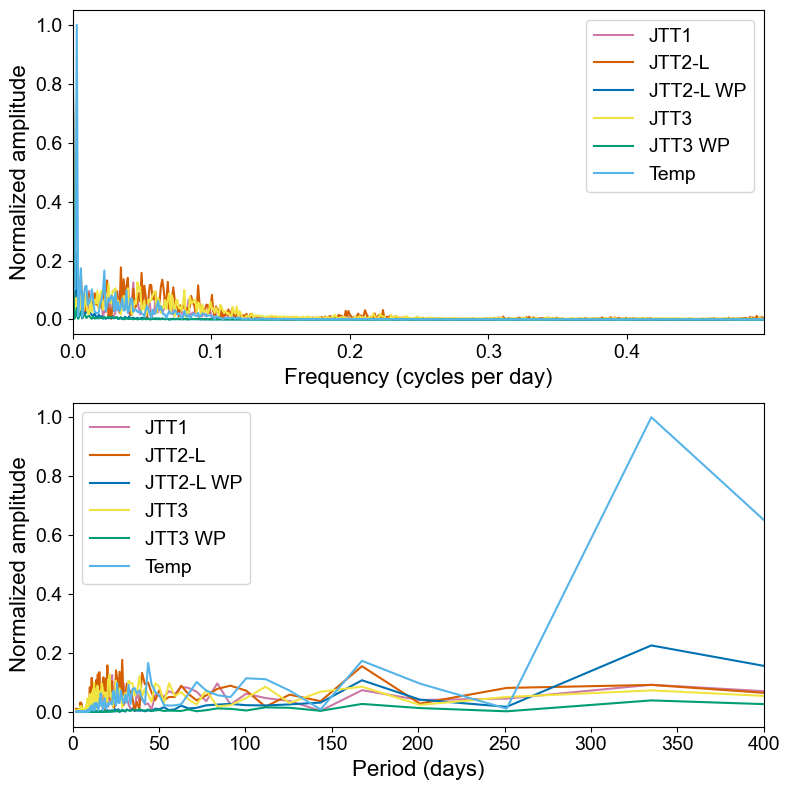

In [26]:
import numpy as np
import matplotlib.pyplot as plt

type = 'original'


# Function to normalize amplitude
def normalize_amplitude(signal):
    fft_result = np.fft.fft(signal)
    amplitude = np.abs(fft_result) / len(signal)
    return (amplitude-np.nanmin(amplitude))/(np.nanmax(amplitude)-np.nanmin(amplitude))

# Plot amplitude vs. frequency
fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), nrows=2)

columns=['JTT1', 'JTT2-L', 'JTT2-L WP', 'JTT3', 'JTT3 WP', 'Temp'] # , 'River', 'Precip', # to be able to turn of some of them

for i,col in enumerate(columns):

    # Number of sample points
    N = int(((df_list[i].index[-1] - df_list[i].index[0]) / np.timedelta64(1, 'D')))
    # Sample spacing
    T = 1.0  # frequency per day
    t = np.linspace(0.0, N * T, N)  # Time variable
    
    signal = df_list[i].loc[:, type].values
    
    # Normalize the amplitude
    amplitude = normalize_amplitude(signal)
    
    # Get the corresponding frequencies
    n = len(signal)
    frequencies = np.fft.fftfreq(n, d=(t[1] - t[0]))
    
    ax1.plot(frequencies[:n // 2], amplitude[:n // 2], label=f'{col}', color=colors[i])  # Only positive frequencies
    ax1.set_xlabel("Frequency (cycles per day)")
    ax1.set_ylabel("Normalized amplitude")
    
    # Convert frequencies to periods (T = 1/f), avoid division by zero
    periods = np.where(frequencies != 0, 1 / frequencies, 0)
    
    # Mask out very small periods (e.g., less than 1 day) to avoid clutter
    valid_idx = periods > 1  # Only include periods greater than 1 day
    
    # Plot amplitude vs. period (focus on positive frequencies/periods)
    ax2.plot(periods[valid_idx][:n // 2], amplitude[valid_idx][:n // 2],  label=f'{col}', color=colors[i])  # Only positive frequencies

# Adjust x-axis limits to focus on relevant periods (0 to 400 days)
ax2.set_xlim(0, 400)
ax2.set_xlabel("Period (days)")
ax2.set_ylabel("Normalized amplitude")

# Final touches
ax1.legend()
ax2.legend()
plt.tight_layout()

# Upper plot. No daily signal, just longer duration signals as it dies above 0.1
# Lower plot. There are several spikes over the year with a peak yearly signal, and several peaks, bi-yearly, and around quarterly signals

### Cross correlation

In [57]:
df.head()

,JTT1,JTT2-L,JTT2-L WP,JTT3,JTT3 WP,Temp,Precip,River,JTT1_GST
2019-09-15,-0.032858,-0.036926,14.749592,0.001259,4.937227,6.062035,24.484715,4.187576,8.11
2019-09-22,0.057762,0.016506,15.111389,0.034330,5.073722,0.409583,8.996503,3.638517,2.20
2019-09-29,0.052967,0.054754,14.917231,0.086387,5.059749,1.975105,4.020646,3.51564,3.02
2019-10-06,0.045002,0.184100,14.782718,0.090194,5.060311,-0.800093,2.939594,3.333006,0.01
2019-10-13,0.126024,0.057591,14.117637,0.038075,4.985828,-2.678284,0.713487,2.743034,-0.66


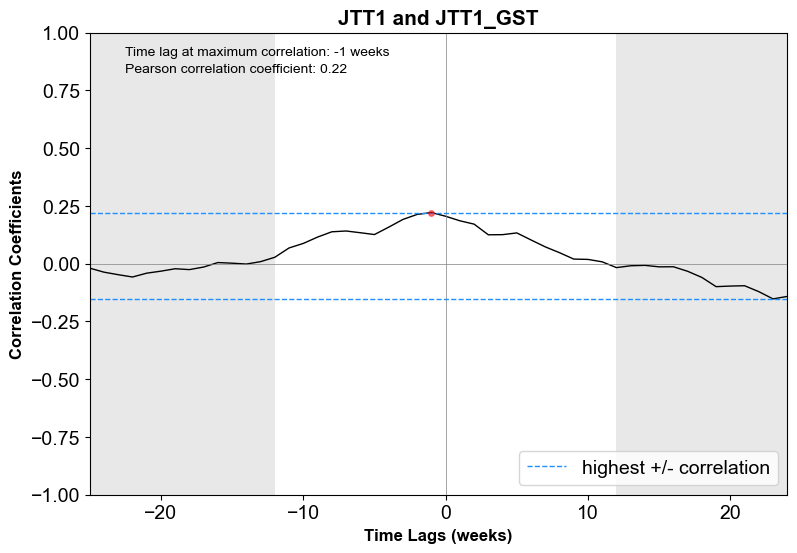

In [41]:
# This method is good. Same outcome as for statsmodels ccf

# Do correlations on stationary variables!

crosscorr_lag = 6 # tried 3 months did not work, tried 12 months = too much. Try 6 months now and only look at 3 months by graying out the boarders.

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,1] #  JTT2-L

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,2] #  JTT2-L WP

# series1 = df.iloc[:,0] P

# series1 = df.iloc[:,0] #  JTT1
# series2 = df.iloc[:,5] #  Temp

series1 = df.iloc[:,0] #  JTT1
series2 = df.iloc[:,8] #  GST

# series1 = df.iloc[:,3] #  JTT3
# series2 = df.iloc[:,4] #  JTT3 WP

# Set the maximum lag you want to consider

#### frequency ####
if interval == '1D':
    h = 1 # per day 
    time_inter = 'days'
if interval == '1W':
    h = 1/7 # per week 
    time_inter = 'weeks'
if interval == '1M':
    h = 1/30 # per week 
    time_inter = 'months'
#######################
n_months = crosscorr_lag
period = int(h*90) # we assume correlation should happen within 90 days # to make sure it is an integer number
max_lag = int(n_months*30*h) # to make sure it is an integer number
lags = range(-max_lag, max_lag)

# Initialize arrays to store results
correlation_coefficients = []
p_values = []

# Loop through different time lags (both positive and negative)
for lag in lags:
    # Calculate Pearson correlation coefficient and p-value
    if lag < 0:
        correlation_coefficient, p_value = pearsonr(series1[:lag], series2[-lag:])
    elif lag == 0:
        correlation_coefficient, p_value = pearsonr(series1, series2)
    else:
        correlation_coefficient, p_value = pearsonr(series1[lag:], series2[:-lag])
    
    # Append results to arrays
    correlation_coefficients.append(correlation_coefficient)
    p_values.append(p_value)

# # Find the lag with the maximum absolute correlation for entire time series
# max_corr_index = np.argmax(np.abs(correlation_coefficients))
# max_corr_lag = lags[max_corr_index]

# Find the lag with the maximum absolute correlation within +/- 3 months
corr_window = correlation_coefficients[period:period*3]
max_corr_index = np.argmax(np.abs(corr_window))
max_corr_lag = lags[period:period*3][max_corr_index]

n_std = 2
small_size = 10

import scipy.stats as st 
def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf, color='black', lw=1)
    ax.axvline(x = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = np.max(ccf), color = 'dodgerblue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'dodgerblue', lw = 1, linestyle='--')
    ax.plot(max_corr_lag, corr_window[max_corr_index], color='red', marker='o', markersize=4, alpha=0.5) # zorder=0 # point to highlight max within corr_window # point to highlight max within corr_window
    
    # # 2 x std
    # ax.axhline(y = np.mean(ccf)+n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--', label = f'{n_std} x std')
    # ax.axhline(y = np.mean(ccf)-n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--')
    # # # 1 x std
    # # ax.axhline(y = np.mean(ccf)+1*np.std(ccf), color = 'red', lw = 1, linestyle='--', label = f'{1} x std')
    # # ax.axhline(y = np.mean(ccf)-1*np.std(ccf), color = 'red', lw = 1, linestyle='--')
    
    # gray out area
    ax.axvspan(lags_plot[0], -period, facecolor='lightgray', alpha=0.5)
    ax.axvspan(+period,lags_plot[-1], facecolor='lightgray', alpha=0.5)
    
    # text in the plot
    y_pos = lags_plot[0]-(lags_plot[0]*0.1)
    ax.text(y_pos, 0.90, f'Time lag at maximum correlation: {max_corr_lag:.0f} {time_inter}', horizontalalignment='left', color='k', fontsize=small_size)
    ax.text(y_pos, 0.83, f'Pearson correlation coefficient: {corr_window[max_corr_index]:.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    # ax.text(y_pos, 0.76, f'2 x standard deviation: +{np.mean(ccf)+n_std*np.std(ccf):.2f}/{np.mean(ccf)-n_std*np.std(ccf):.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    pval = []
    # if p_values[max_corr_index] < 0.001:
    #     ax.text(y_pos, 0.69, f'P-value: <0.001', horizontalalignment='left', color='k', fontsize=small_size)
    # else:
    #     ax.text(y_pos, 0.69, f'P-value: {p_values[max_corr_index]:.3f}', horizontalalignment='left', color='k', fontsize=small_size)
    
    # cosmetics
    ax.set(ylim = [-1, 1])
    ax.set_title(f'{series1.name} and {series2.name}', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel(f'Time Lags ({time_inter})', weight='bold', fontsize = 12)
    
    plt.legend(loc='lower right')
    
    # saving
    path = 'plots\\'
    save_name = f'{path}crosscorr_{series1.name}_{series2.name}_lag{n_months}.png'
    fig.savefig(save_name, dpi=300, bbox_inches='tight')
    
# setting size of plotting window
lags_plot = np.linspace(lags[0],lags[-1], num=int(max_lag*2)) # use the interval of df

ccf_plot(lags_plot, correlation_coefficients)

# the first variable (x) is leading if negative lage time, and second variable (y) is leading if positive lag time

### Modeling

In [11]:
df_features = df[['JTT1', 'JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River', 'dv/v','JTT1_GST']] # 'JTT2-L','JTT2-L WP',
# df_features = df[['Disp', 'WP', 'Precip', 'Temp', 'River', 'WP*Temp', 'WP**2']] # 'Precip', need more than two years to add these ,'WP*Temp', 'WP**2']].reset_index(drop=True) # Nonlinear part

# # Tried adding month as predictor, did not show any significance..
# df['Month'] = df.index.month
# df_features = df[['Disp', 'WP', 'Month']]

# Scaling
# now scale and transform data so variables are of similar weight 
#(If you are developing a model that has a scientific value then you need to get rid of the units of the input variables. That’s because a model, if it is fundamental, should not depend on the particular units you use (https://www.quora.com/Should-you-standardise-data-before-regression))
from sklearn.preprocessing import MinMaxScaler

# Scale together
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
scaled_combined = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns, index=df_features.index)

# Split into train and test
cutoff_index = scaled_combined.index[int(scaled_combined.shape[0] * 0.80)] # train with X % data. 80 % is not enough to make stationary, but 85 % is.
# cutoff_index = pd.Timestamp('2022-01-01')
df_train = scaled_combined.loc[:cutoff_index]
df_test = scaled_combined.loc[cutoff_index:]

# Separate back into response and explanatory
response = df_train[['JTT1']]
# explanatory = scaled_combined[['JTT2-L WP', 'Temp']]
# explanatory = scaled_combined[['JTT3', 'JTT3 WP']] # only bh3
# explanatory = scaled_combined[['JTT2-L', 'JTT3']] # only borehole effects 
explanatory = df_train[['JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River', 'dv/v', 'JTT1_GST']] # all variables 'JTT2-L','JTT2-L WP',

In [13]:
response.tail()

,JTT1
2022-10-23,0.668136
2022-10-30,0.570761
2022-11-06,0.526621
2022-11-13,0.329338
2022-11-20,0.394652


In [15]:
%%time 
# need to have statinary data before running model
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

# forsøk uten AR term, endog_lag = 0

df_features = df[['JTT1', 'JTT2-L','JTT2-L WP', 'JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River']]
# df_features = df[['Disp', 'WP', 'Precip', 'Temp', 'River', 'WP*Temp', 'WP**2']] # 'Precip', need more than two years to add these ,'WP*Temp', 'WP**2']].reset_index(drop=True) # Nonlinear part
# # Tried adding month as predictor, did not show any significance..
# df['Month'] = df.index.month
# df_features = df[['Disp', 'WP', 'Month']]

# Scaling
# now scale and transform data so variables are of similar weight 
#(If you are developing a model that has a scientific value then you need to get rid of the units of the input variables. That’s because a model, if it is fundamental, should not depend on the particular units you use (https://www.quora.com/Should-you-standardise-data-before-regression))
from sklearn.preprocessing import MinMaxScaler

# Scale together
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
scaled_combined = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns, index=df_features.index)

# Separate back into response and explanatory
response = scaled_combined[['JTT1']]
# explanatory = scaled_combined[['Temp', 'Precip', 'River']]
# explanatory = scaled_combined[['JTT3', 'JTT3 WP']] # only bh3
# explanatory = scaled_combined[['JTT2-L', 'JTT3']] # only borehole effects 
explanatory = scaled_combined[['JTT2-L','JTT2-L WP', 'JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River']] # all variables

# Optimal order with 0 to 90 lags is 3,4,3 for disp, wp, and temp (bic) and 90,90,90 (aic). A bit strange but try and plot and see if it makes sense! It is almost a perfect match for bic

if interval == '1D':
    exog_lag = 90 # 90 days 
if interval == '1W':
    exog_lag = 13 # equal to 90 days 
if interval == '1M':
    exog_lag = 3 # equal to 90 days 

endog_lag = exog_lag

# Set if AR or not for model
# endog_lag = exog_lag # same as explanatory variables
# endog_lag = 0 # No autoregressive term

# Manual selection from bic suggestion ardl_select_order
# Define the lag orders for the dependent variable and each exogenous variable
endog_lag = 1
exog_lags = endog_lag # {'JTT2-L': 4,'JTT2-L WP': 5, 'JTT3': 6, 'JTT-3 WP', 'Temp', 'Precip', 'River'}

# Set up the ARDL model with specified lags
m1 = ARDL(response, endog_lag, explanatory, exog_lags, trend="n").fit()

# # Automatic selection based on bic or aic, this takes very long time with multiple variables, rows and lags..
# # endog_lag = 13
# sel_res = ardl_select_order(response, endog_lag, explanatory, exog_lag, ic="bic", trend="n") # n equals no trend or constant i.e. differenced data as I now have. If using the disp data need 'ct' consant with trend. This is in respect of the dependent/response variable
# print(f'The optimal order is: {sel_res.model.ardl_order}')
# m1 = sel_res.model.fit()

# Get parameters and p-values directly
params = m1.params  # Coefficients of the model
pvalues = m1.pvalues  # Corresponding p-values

significant_params = params[pvalues < 0.05]
significant_pvalues = pvalues[pvalues < 0.05]

# Create a DataFrame for significant results
significant_results = pd.DataFrame({
    'Variable': significant_params.index,
    'Coefficient': significant_params.values,
    'P-Value': significant_pvalues.values
})

# Set 'Variable' as the index for better readability
significant_results.set_index('Variable', inplace=True)

# # Display the DataFrame with significant results
# print('significant parameters: \n', significant_results)
print('\nsummary: \n', m1.summary())
print('\n\nSignificant coefs: \n', significant_results)


summary: 
                                    ARDL Model Results                                   
Dep. Variable:                             JTT1   No. Observations:                  153
Model:             ARDL(1, 1, 1, 1, 1, 1, 1, 1)   Log Likelihood                  91.039
Method:                         Conditional MLE   S.D. of innovations              0.133
Date:                          Mon, 20 Jan 2025   AIC                           -150.079
Time:                                  10:03:34   BIC                           -101.697
Sample:                                       1   HQIC                          -130.424
                                            153                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
JTT1.L1          0.4028      0.076      5.280      0.000       0.252       0.554
JTT2-L.L0        0.1071      0.06

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
# 1 resp and 2 exp 1h 23m
# ridge regression? Some multicoliniarity in the model? # Try a nonlinear model: dispt = α+β⋅log(wp[t−45])+ϵt

[2.5004613592250933, -2.115507190689437, 0.6144646823961271]

In [177]:
# # variables to consider
# df_features = df[['JTT1', 'JTT2-L','JTT2-L WP', 'JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River']]
# # df_features = df[['Disp', 'WP', 'Precip', 'Temp', 'River', 'WP*Temp', 'WP**2']] # 'Precip', need more than two years to add these ,'WP*Temp', 'WP**2']].reset_index(drop=True) # Nonlinear part

# # Scale data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
# scaled_combined = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns, index=df_features.index)

# # Separate back into response and explanatory
# response = scaled_combined[['JTT1']]
# explanatory = scaled_combined[['JTT2-L','JTT2-L WP', 'JTT3', 'JTT3 WP', 'Temp', 'Precip', 'River']] 
# explanatory = scaled_combined[['WP', 'Temp', 'Precip', 'River', 'WP*Temp', 'WP**2']] 

# Define the lag range and variable names

exog_lag = 2 # number of lags
endog_lag = exog_lag # same as explanatory variables
exog_lag_range = endog_lag + 1
exog_vars = explanatory.columns # variable to help iteration
total_combinations = exog_lag_range ** (1 + len(exog_vars))  # Total combinations

start_timestamp = datetime.now().strftime("%A %d %B %H:%M:%S")
print(f'Start fitting {exog_lag} lags resulting in {total_combinations} combinations at {start_timestamp}')

import time
import os

start_wall_time = time.time()  # Wall time
start_cpu_time = os.times().user  # CPU time


# ChatGPT's suggestion to fit combinations on the fly to save memory
import itertools
import time
import gc
import logging
from joblib import Parallel, delayed
from statsmodels.tsa.ardl import ARDL
import multiprocessing as mp

# Suppress warning
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

# Configure logging
logging.basicConfig(
    filename="ardl_debug.log",
    level=logging.DEBUG,  # Adjust level to DEBUG to capture all details
    format="%(asctime)s - %(levelname)s - %(message)s")


# Setup multiprocessing
num_cores = mp.cpu_count() # Number of parallel processes
print(f'Using {num_cores} cores for parallel processing.')

# Function to generate combinations dynamically
def generate_combinations(start, stop, lag_range, num_vars):
    # Manually calculate combinations based on indices
    total_combinations = lag_range ** num_vars
    for index in range(start, min(stop, total_combinations)):
        # Convert index to a tuple of lag values
        combo = []
        temp = index
        for _ in range(num_vars):
            combo.append(temp % lag_range)
            temp //= lag_range
        yield tuple(reversed(combo))

# Parallel processing function with dynamically generated combinations inside to save memory
def fit_ardl_with_ranges(start, stop, lag_range, num_vars):
    best_bic = float('inf')
    best_combo = None

    # Generate combinations within the range
    for combo in generate_combinations(start, stop, lag_range, num_vars):
        start_time = time.time()
        try:
            endog_lag = int(combo[0])
            exog_lags = {var: int(combo[idx + 1]) for idx, var in enumerate(exog_vars)}
            
            logging.debug(f"Starting combo: {combo}")
            
            # Fit ARDL model
            mod = ARDL(response, endog_lag, explanatory, exog_lags, trend="n").fit()
            bic = mod.bic
            
            logging.debug(f"Combination {combo} completed with BIC: {bic:.4f}")
            
            if bic < best_bic:
                best_bic = bic
                best_combo = combo
            
            del mod
            gc.collect()

        except Exception as e:
            logging.error(f"Error for combo {combo}: {e}")

        finally:
            elapsed_time = time.time() - start_time
            if elapsed_time > 600:  # Example: 10 minutes
                logging.warning(f"Combination {combo} took too long: {elapsed_time:.2f} seconds.")
    
    return best_bic, best_combo

chunk_size = total_combinations // num_cores  # Divide by number of cores

results = Parallel(n_jobs=num_cores, backend='loky')(
    delayed(fit_ardl_with_ranges)(
        i * chunk_size, (i + 1) * chunk_size, exog_lag_range, len(exog_vars) + 1
    )
    for i in range(num_cores)
)

# Collect and analyze results
best_bic_overall = float('inf')
best_params = None
for result in results:
    bic, combo = result
    if bic < best_bic_overall:
        best_bic_overall = bic
        best_params = combo

print(f"Overall Best BIC: {best_bic_overall} with combination: {best_params}")

# Fit the best model once more with best parameters
if best_params:
    endog_lag = int(best_params[0])
    exog_lags = {var: int(best_params[idx + 1]) for idx, var in enumerate(exog_vars)}
    m1 = ARDL(response, endog_lag, explanatory, exog_lags, trend="n").fit()

# Restore warnings
warnings.filterwarnings("default")

# timing function
end_wall_time = time.time()
end_cpu_time = os.times().user

end_timestamp = datetime.now().strftime("%A %d %B %H:%M:%S")
print(f'End fitting at the {end_timestamp}')

print(f"Wall time: {end_wall_time - start_wall_time:.6f} seconds")
print(f"CPU time: {end_cpu_time - start_cpu_time:.6f} seconds")

print('\nsummary: \n', m1.summary())

Start fitting 2 lags resulting in 27 combinations at Wednesday 22 January 16:35:23
Using 8 cores for parallel processing.
Overall Best BIC: -142.44306504166093 with combination: (1, 0, 0)
End fitting at the Wednesday 22 January 16:35:24
Wall time: 0.828749 seconds
CPU time: 0.031250 seconds

summary: 
                               ARDL Model Results                              
Dep. Variable:                   JTT1   No. Observations:                  153
Model:                  ARDL(1, 0, 0)   Log Likelihood                  81.269
Method:               Conditional MLE   S.D. of innovations              0.142
Date:                Wed, 22 Jan 2025   AIC                           -154.539
Time:                        16:35:24   BIC                           -142.443
Sample:                             1   HQIC                          -149.625
                                  153                                         
                   coef    std err          z      P>|z|      [0

In [109]:
# I think I lack importing some functions
from statsmodels.compat.pandas import call_cached_func #  Appender, Substitution, 
from statsmodels.tsa.ar_model import sumofsq #     AROrderSelectionResults, AutoReg, AutoRegResults,
from statsmodels.tsa.ardl import ARDLResults

def compute_ics(y, x, df):
        if x.shape[1]:
            resid = y - x @ np.linalg.lstsq(x, y, rcond=None)[0]
        else:
            resid = y
        nobs = resid.shape[0]
        sigma2 = 1.0 / nobs * sumofsq(resid)
        llf = -nobs * (np.log(2 * np.pi * sigma2) + 1) / 2
        res = SimpleNamespace(
            nobs=nobs, df_model=df + x.shape[1], sigma2=sigma2, llf=llf
        )

        aic = call_cached_func(ARDLResults.aic, res)
        bic = call_cached_func(ARDLResults.bic, res)

        return bic

response = scaled_combined[['JTT1']]
explanatory = scaled_combined[['JTT2-L','JTT2-L WP']]

y = response.values
x = explanatory.values
lags = 3

for lag in range(lags+1):
    lag = lag 
    y_lagged = np.roll(y, lag)
    y_lagged[:lags] = 0  # Adjust for missing lags at the start

    x_lagged = np.column_stack([np.roll(x[:, i], lag) for i in range(x.shape[1])])
    x_lagged[:lag, :] = 0  # Adjust for missing lag at the start
    df = x_lagged.shape[1]  # Number of lagged variables
    
    print(f'bic{lag}: {compute_ics(y_lagged, x_lagged, df)[0]}')

for lag in range(lags+1):
    print(f'bic{lag}: {ARDL(y, lag, x, lag, trend="n").fit().bic}')

bic0: -79.56781942707744
bic1: -83.3256061564481
bic2: -93.00890857608705
bic3: -98.9162347304178
bic0: -84.09346444257675
bic1: -134.16782564007053
bic2: -119.02037638090653
bic3: -126.16102427276576


In [78]:
import itertools
import time
import gc
from joblib import Parallel, delayed
from statsmodels.tsa.ardl import ARDL
import multiprocessing as mp
from __future__ import annotations

from statsmodels.compat.pandas import Appender, Substitution, call_cached_func

from collections import defaultdict
from collections.abc import Hashable, Mapping, Sequence
import datetime as dt
from itertools import combinations, product
import textwrap
from types import SimpleNamespace
from typing import TYPE_CHECKING, Any, Literal, NamedTuple, Optional, Union
import warnings

import numpy as np
import pandas as pd
from scipy import stats

from statsmodels.base.data import PandasData
import statsmodels.base.wrapper as wrap
from statsmodels.iolib.summary import Summary, summary_params
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.decorators import cache_readonly
from statsmodels.tools.docstring import Docstring, Parameter, remove_parameters
from statsmodels.tools.sm_exceptions import SpecificationWarning
from statsmodels.tools.typing import (
    ArrayLike1D,
    ArrayLike2D,
    Float64Array,
    NDArray,
)
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    float_like,
    int_like,
)
from statsmodels.tsa.ar_model import (
    AROrderSelectionResults,
    AutoReg,
    AutoRegResults,
    sumofsq,
)
from statsmodels.tsa.ardl import pss_critical_values
from statsmodels.tsa.arima_process import arma2ma
from statsmodels.tsa.base import tsa_model
from statsmodels.tsa.base.prediction import PredictionResults
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.ardl import ARDLOrderSelectionResults
from statsmodels.tsa.ardl import ARDLResults
import warnings

# ### Trying to debugg memory error
# import sys
# import logging
# import io as i_o
# # Create an in-memory log buffer
# log_stream = i_o.StringIO()

# # Configure logging to write to the in-memory buffer
# logging.basicConfig(
#     stream=log_stream,
#     level=logging.INFO,
#     format="%(asctime)s - %(levelname)s - %(message)s",
# )

# Suppress warning
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

def ardl_select_order(
    endog: ArrayLike1D | ArrayLike2D,
    maxlag: int,
    exog: ArrayLike2D,
    maxorder: int | dict[Hashable, int],
    trend: Literal["n", "c", "ct", "ctt"] = "c",
    *,
    fixed: ArrayLike2D | None = None,
    causal: bool = False,
    ic: Literal["aic", "bic"] = "bic",
    glob: bool = False,
    seasonal: bool = False,
    deterministic: DeterministicProcess | None = None,
    hold_back: int | None = None,
    period: int | None = None,
    missing: Literal["none", "raise"] = "none",
) -> ARDLOrderSelectionResults:

    def compute_ics(y, x, df):
        if x.shape[1]:
            resid = y - x @ np.linalg.lstsq(x, y, rcond=None)[0]
        else:
            resid = y
        nobs = resid.shape[0]
        sigma2 = 1.0 / nobs * sumofsq(resid)
        llf = -nobs * (np.log(2 * np.pi * sigma2) + 1) / 2
        res = SimpleNamespace(
            nobs=nobs, df_model=df + x.shape[1], sigma2=sigma2, llf=llf
        )

        aic = call_cached_func(ARDLResults.aic, res)
        bic = call_cached_func(ARDLResults.bic, res)
        hqic = call_cached_func(ARDLResults.hqic, res)
        del resid # free memory

        return aic, bic, hqic

    base = ARDL(
        endog,
        maxlag,
        exog,
        maxorder,
        trend,
        fixed=fixed,
        causal=causal,
        seasonal=seasonal,
        deterministic=deterministic,
        hold_back=hold_back,
        period=period,
        missing=missing,
    )
    hold_back = base.hold_back
    blocks = base._blocks
    always = np.column_stack([blocks["deterministic"], blocks["fixed"]])
    always = always[hold_back:]
    select = []
    iter_orders = []
    select.append(blocks["endog"][hold_back:])
    iter_orders.append(list(range(blocks["endog"].shape[1] + 1)))
    var_names = []
    for var in blocks["exog"]:
        block = blocks["exog"][var][hold_back:]
        select.append(block)
        iter_orders.append(list(range(block.shape[1] + 1)))
        var_names.append(var)
    y = base._y

    # Trying to add parallel processing for this step
    
    # Function to generate combinations dynamically
    def generate_combinations(start, stop, lag_range, num_vars):
        # Manually calculate combinations based on indices
        total_combinations = lag_range ** num_vars
        for index in range(start, min(stop, total_combinations)):
            # Convert index to a tuple of lag values
            combo = []
            temp = index
            for _ in range(num_vars):
                combo.append(temp % lag_range)
                temp //= lag_range
            yield tuple(reversed(combo))
    
    ######## Parallel processing function with dynamically generated combinations inside to save memory
    def fit_ardl_with_ranges(start, stop, lag_range, num_vars):
        ics = {}
        best_bic = float('inf')
        best_combo = None
        
        # manager = mp.Manager()
        # progress = manager.Value('d', 0.0)  # Shared variable to store progress

        # log_stream = i_o.StringIO()
        # logging.basicConfig(
        #     stream=log_stream,
        #     level=logging.INFO,
        #     format="%(asctime)s - %(processName)s - %(levelname)s - %(message)s",
        # )
        # # check_interval = 1000  # Check growth every 1000 combinations
    
        # Generate combinations within the range
        for count, io in enumerate(generate_combinations(start, stop, lag_range, num_vars)):
            percentage = (count/stop)*100
            # progress.value = percentage
            if count % (stop // 50) == 0:  # Print every 1000, 0.1% 100, 1%, 50, 5%
                print(f"\rFinished: {int(percentage)} %", end="", flush=True)
            x = np.column_stack([a[:, : io[i]] for i, a in enumerate(select)])
            key = [io[0] if io[0] else None]
            for j, val in enumerate(io[1:]):
                var = var_names[j]
                if causal:
                    key.append((var, None if val == 0 else val))
                else:
                    key.append((var, val - 1 if val - 1 >= 0 else None))
            key = tuple(key)

             # Compute ICs without storing all in ics
            aic, bic, hqic = compute_ics(y, x, 0)
            if bic < best_bic:
                best_bic = bic
                best_order = key
    
            del x  # Free memory for x after usage
    
        return best_bic, best_order
    
        #     ics[key] = compute_ics(y, x, 0) # 0 degrees of freedom
        #     # Periodically monitor ics growth
        #     if count % check_interval == 0:
        #         logging.info(f"Processed {count} combinations")
        #         logging.info(f"Number of entries in ics: {len(ics)}")
        
        # index = {"aic": 0, "bic": 1, "hqic": 2}[ic]
        # lowest = np.inf
        # for key in ics:
        #     val = ics[key][index]
        #     if val < lowest:
        #         lowest = val
        #         selected_order = key
        # # return lowest, selected_order
        # return ics #log_stream.getvalue()
    
    # single core processing
    results = fit_ardl_with_ranges(0, total_combinations, exog_lag_range, len(exog_vars) + 1) # To test without parallel processing
    print(f"\nOverall Best BIC: {results[0]} with combination: {results[1:]}")
    return results #best_bic_overall, best_params
    
    # # Parallel processing part
    # # Setup multiprocessing
    # num_cores = mp.cpu_count() # Number of parallel processes
    # print(f'Using {num_cores} cores for parallel processing...')
    # chunk_size = total_combinations // num_cores  # Divide by number of cores
    # results = Parallel(n_jobs=num_cores, backend='loky')(
    #     delayed(fit_ardl_with_ranges)(
    #         i * chunk_size, (i + 1) * chunk_size, exog_lag_range, len(exog_vars) + 1
    #     )
    #     for i in range(num_cores)
    # )

    # # # Print progress periodically from the main process
    # # try:
    # #     while any(result is None for result in results):
    # #         print(f"\rFinished: {progress.value:.2f} %", end="", flush=True)
    # #         time.sleep(1)  # Wait for 1 second before checking again
    # # except KeyboardInterrupt:
    # #     print("\nProcess interrupted!")
    
    # # Collect and analyze results
    # best_bic_overall = float('inf')
    # best_params = None
    # for result in results:
    #     bic, combo = result
    #     if bic < best_bic_overall:
    #         best_bic_overall = bic
    #         best_params = combo

    # print(f"Overall Best BIC: {best_bic_overall} with combination: {best_params}")
    # return results #best_bic_overall, best_params

    #########

    # ics = {}
    # for io in product(*iter_orders):
    #     print(io)
    #     x = np.column_stack([a[:, : io[i]] for i, a in enumerate(select)])
    #     key = [io[0] if io[0] else None]
    #     for j, val in enumerate(io[1:]):
    #         var = var_names[j]
    #         if causal:
    #             key.append((var, None if val == 0 else val))
    #         else:
    #             key.append((var, val - 1 if val - 1 >= 0 else None))
    #     key = tuple(key)
    #     ics[key] = compute_ics(y, x, 0) # 0 degrees of freedom
    # index = {"aic": 0, "bic": 1, "hqic": 2}[ic]
    # lowest = np.inf
    # for key in ics:
    #     val = ics[key][index]
    #     if val < lowest:
    #         lowest = val
    #         selected_order = key
            
    # return ARDLOrderSelectionResults(model=None, ics, trend=None, seasonal=None, period=None)        # original 
    # return lowest, selected_order  

### Var needed to run function

exog_lag = 13 # number of lags (13 weeks is 90 day lag)
endog_lag = exog_lag # same as explanatory variables
exog_lag_range = endog_lag + 1
exog_vars = explanatory.columns # variable to help iteration
total_combinations = exog_lag_range ** (1 + len(exog_vars))  # Total combinations

start_timestamp = datetime.now().strftime("%A %d %B %H:%M:%S")
print(f'Start fitting {exog_lag} lags resulting in {total_combinations} combinations at {start_timestamp}')

import time
import os

start_wall_time = time.time()  # Wall time
start_cpu_time = os.times().user  # CPU time

results = ardl_select_order(response, endog_lag, explanatory, exog_lag, ic="bic", trend="n") # function

# Restore warnings
warnings.filterwarnings("default")

# timing function
end_wall_time = time.time()
end_cpu_time = os.times().user

end_timestamp = datetime.now().strftime("%A %d %B %H:%M:%S")
print(f'\nEnd fitting at the {end_timestamp}')

print(f"Wall time: {end_wall_time - start_wall_time:.2f} seconds or {(end_wall_time - start_wall_time)/60} minutes")
print(f"CPU time: {end_cpu_time - start_cpu_time:.6f} seconds")

Start fitting 13 lags resulting in 1475789056 combinations at Wednesday 07 May 13:02:00
Finished: 3 %

KeyboardInterrupt: 

In [27]:
results

NameError: name 'results' is not defined

In [72]:
print(total_combinations)
(533.95/60/1679616*total_combinations)/60 # 5.5 days or 131 hours to run 13 lags

1475789056


130.32039043633256

In [ ]:
# 2 lags 7 variables weekly data
# 10 sec with 8 cores
# 2 sec with 1 core, seems like 1 core is fine. Looks like it use all of avalable resources anyway for some reason??

In [42]:
from __future__ import annotations

from statsmodels.compat.pandas import Appender, Substitution, call_cached_func

from collections import defaultdict
from collections.abc import Hashable, Mapping, Sequence
import datetime as dt
from itertools import combinations, product
import textwrap
from types import SimpleNamespace
from typing import TYPE_CHECKING, Any, Literal, NamedTuple, Optional, Union
import warnings

import numpy as np
import pandas as pd
from scipy import stats

from statsmodels.base.data import PandasData
import statsmodels.base.wrapper as wrap
from statsmodels.iolib.summary import Summary, summary_params
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.decorators import cache_readonly
from statsmodels.tools.docstring import Docstring, Parameter, remove_parameters
from statsmodels.tools.sm_exceptions import SpecificationWarning
from statsmodels.tools.typing import (
    ArrayLike1D,
    ArrayLike2D,
    Float64Array,
    NDArray,
)
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    float_like,
    int_like,
)
from statsmodels.tsa.ar_model import (
    AROrderSelectionResults,
    AutoReg,
    AutoRegResults,
    sumofsq,
)
from statsmodels.tsa.ardl import pss_critical_values
from statsmodels.tsa.arima_process import arma2ma
from statsmodels.tsa.base import tsa_model
from statsmodels.tsa.base.prediction import PredictionResults
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.ardl import ARDLOrderSelectionResults

def ardl_select_order(
    endog: ArrayLike1D | ArrayLike2D,
    maxlag: int,
    exog: ArrayLike2D,
    maxorder: int | dict[Hashable, int],
    trend: Literal["n", "c", "ct", "ctt"] = "c",
    *,
    fixed: ArrayLike2D | None = None,
    causal: bool = False,
    ic: Literal["aic", "bic"] = "bic",
    glob: bool = False,
    seasonal: bool = False,
    deterministic: DeterministicProcess | None = None,
    hold_back: int | None = None,
    period: int | None = None,
    missing: Literal["none", "raise"] = "none",
) -> ARDLOrderSelectionResults:
    r"""
    ARDL order selection

    Parameters
    ----------
    endog : array_like
        A 1-d endogenous response variable. The dependent variable.
    maxlag : int
        The maximum lag to consider for the endogenous variable.
    exog : array_like
        Exogenous variables to include in the model. Either a DataFrame or
        an 2-d array-like structure that can be converted to a NumPy array.
    maxorder : {int, dict}
        If int, sets a common max lag length for all exog variables. If
        a dict, then sets individual lag length. They keys are column names
        if exog is a DataFrame or column indices otherwise.
    trend : {'n', 'c', 't', 'ct'}, optional
        The trend to include in the model:

        * 'n' - No trend.
        * 'c' - Constant only.
        * 't' - Time trend only.
        * 'ct' - Constant and time trend.

        The default is 'c'.
    fixed : array_like
        Additional fixed regressors that are not lagged.
    causal : bool, optional
        Whether to include lag 0 of exog variables.  If True, only includes
        lags 1, 2, ...
    ic : {"aic", "bic", "hqic"}
        The information criterion to use in model selection.
    glob : bool
        Whether to consider all possible submodels of the largest model
        or only if smaller order lags must be included if larger order
        lags are.  If ``True``, the number of model considered is of the
        order 2**(maxlag + k * maxorder) assuming maxorder is an int. This
        can be very large unless k and maxorder are bot relatively small.
        If False, the number of model considered is of the order
        maxlag*maxorder**k which may also be substantial when k and maxorder
        are large.
    seasonal : bool, optional
        Flag indicating whether to include seasonal dummies in the model. If
        seasonal is True and trend includes 'c', then the first period
        is excluded from the seasonal terms.
    deterministic : DeterministicProcess, optional
        A deterministic process.  If provided, trend and seasonal are ignored.
        A warning is raised if trend is not "n" and seasonal is not False.
    hold_back : {None, int}, optional
        Initial observations to exclude from the estimation sample.  If None,
        then hold_back is equal to the maximum lag in the model.  Set to a
        non-zero value to produce comparable models with different lag
        length.  For example, to compare the fit of a model with lags=3 and
        lags=1, set hold_back=3 which ensures that both models are estimated
        using observations 3,...,nobs. hold_back must be >= the maximum lag in
        the model.
    period : {None, int}, optional
        The period of the data. Only used if seasonal is True. This parameter
        can be omitted if using a pandas object for endog that contains a
        recognized frequency.
    missing : {"none", "drop", "raise"}, optional
        Available options are 'none', 'drop', and 'raise'. If 'none', no NaN
        checking is done. If 'drop', any observations with NaNs are dropped.
        If 'raise', an error is raised. Default is 'none'.

    Returns
    -------
    ARDLSelectionResults
        A results holder containing the selected model and the complete set
        of information criteria for all models fit.
    """
    orig_hold_back = int_like(hold_back, "hold_back", optional=True)

    def compute_ics(y, x, df):
        if x.shape[1]:
            resid = y - x @ np.linalg.lstsq(x, y, rcond=None)[0]
        else:
            resid = y
        nobs = resid.shape[0]
        sigma2 = 1.0 / nobs * sumofsq(resid)
        llf = -nobs * (np.log(2 * np.pi * sigma2) + 1) / 2
        res = SimpleNamespace(
            nobs=nobs, df_model=df + x.shape[1], sigma2=sigma2, llf=llf
        )

        aic = call_cached_func(ARDLResults.aic, res)
        bic = call_cached_func(ARDLResults.bic, res)
        hqic = call_cached_func(ARDLResults.hqic, res)

        return aic, bic, hqic

    base = ARDL(
        endog,
        maxlag,
        exog,
        maxorder,
        trend,
        fixed=fixed,
        causal=causal,
        seasonal=seasonal,
        deterministic=deterministic,
        hold_back=hold_back,
        period=period,
        missing=missing,
    )
    hold_back = base.hold_back
    blocks = base._blocks
    always = np.column_stack([blocks["deterministic"], blocks["fixed"]])
    always = always[hold_back:]
    select = []
    iter_orders = []
    select.append(blocks["endog"][hold_back:])
    iter_orders.append(list(range(blocks["endog"].shape[1] + 1)))
    var_names = []
    for var in blocks["exog"]:
        block = blocks["exog"][var][hold_back:]
        select.append(block)
        iter_orders.append(list(range(block.shape[1] + 1)))
        var_names.append(var)
    y = base._y
    if always.shape[1]:
        pinv_always = np.linalg.pinv(always)
        for i in range(len(select)):
            x = select[i]
            select[i] = x - always @ (pinv_always @ x)
        y = y - always @ (pinv_always @ y)

    def perm_to_tuple(keys, perm):
        if perm == ():
            d = {k: 0 for k, _ in keys if k is not None}
            return (0,) + tuple((k, v) for k, v in d.items())
        d = defaultdict(list)
        y_lags = []
        for v in perm:
            key = keys[v]
            if key[0] is None:
                y_lags.append(key[1])
            else:
                d[key[0]].append(key[1])
        d = dict(d)
        if not y_lags or y_lags == [0]:
            y_lags = 0
        else:
            y_lags = tuple(y_lags)
        for key in keys:
            if key[0] not in d and key[0] is not None:
                d[key[0]] = None
        for key in d:
            if d[key] is not None:
                d[key] = tuple(d[key])
        return (y_lags,) + tuple((k, v) for k, v in d.items())

    always_df = always.shape[1]
    ics = {}
    if glob:
        ar_lags = base.ar_lags if base.ar_lags is not None else []
        keys = [(None, i) for i in ar_lags]
        for k, v in base._order.items():
            keys += [(k, i) for i in v]
        x = np.column_stack([a for a in select])
        all_columns = list(range(x.shape[1]))
        for i in range(x.shape[1]):
            for perm in combinations(all_columns, i):
                key = perm_to_tuple(keys, perm)
                ics[key] = compute_ics(y, x[:, perm], always_df)
    else:
        for io in product(*iter_orders):
            x = np.column_stack([a[:, : io[i]] for i, a in enumerate(select)])
            key = [io[0] if io[0] else None]
            for j, val in enumerate(io[1:]):
                var = var_names[j]
                if causal:
                    key.append((var, None if val == 0 else val))
                else:
                    key.append((var, val - 1 if val - 1 >= 0 else None))
            key = tuple(key)
            ics[key] = compute_ics(y, x, always_df)
    index = {"aic": 0, "bic": 1, "hqic": 2}[ic]
    lowest = np.inf
    for key in ics:
        val = ics[key][index]
        if val < lowest:
            lowest = val
            selected_order = key
            
    # return ARDLOrderSelectionResults(model=None, ics, trend=None, seasonal=None, period=None)        # original 
    return lowest, selected_order  

ardl_select_order(response, 2, explanatory, 2, ic="bic", trend="n")

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(-151.32852237599036,
 (1,
  ('JTT2-L', None),
  ('JTT2-L WP', None),
  ('JTT3', 1),
  ('JTT3 WP', None),
  ('Temp', None),
  ('Precip', None),
  ('River', None)))

In [44]:
from statsmodels.tsa.ardl import ardl_select_order
ardl_select_order(response, 2, explanatory, 2, ic="bic", trend="n").bic

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


BIC
-151.328522    (1, {'JTT2-L': None, 'JTT2-L WP': None, 'JTT3'...
-148.019244    (1, {'JTT2-L': 0, 'JTT2-L WP': None, 'JTT3': 1...
-147.010512    (1, {'JTT2-L': None, 'JTT2-L WP': None, 'JTT3'...
-147.005430    (1, {'JTT2-L': None, 'JTT2-L WP': None, 'JTT3'...
-146.596972    (1, {'JTT2-L': None, 'JTT2-L WP': None, 'JTT3'...
                                     ...                        
 16.664964     (None, {'JTT2-L': None, 'JTT2-L WP': None, 'JT...
 26.112911     (None, {'JTT2-L': None, 'JTT2-L WP': None, 'JT...
 29.104171     (None, {'JTT2-L': None, 'JTT2-L WP': None, 'JT...
 29.488051     (None, {'JTT2-L': None, 'JTT2-L WP': None, 'JT...
 75.194695     (None, {'JTT2-L': None, 'JTT2-L WP': None, 'JT...
Name: BIC, Length: 49152, dtype: object

In [69]:
from itertools import product
from joblib import Parallel, delayed
from statsmodels.tsa.api import ardl_select_order

def select_order_subset(y, X, combination, trend):
    """
    Helper function to run ARDL order selection on a subset of combinations.
    """
    max_lags = combination[0]  # First value is the lag of the dependent variable
    exog_lags = combination[1:]  # Remaining values are lags for each explanatory variable

    result = ardl_select_order(
        endog=y, exogX, maxlag=max_lags, max_lags_exog=exog_lags, trend=trend, method='grid_search'
    )
    
    return result.aic, (max_lags, *exog_lags)

def parallel_ardl_selection(endog, exog, max_lags, trend="n", num_cores=8):
    """
    Parallel ARDL lag selection using ardl_select_order.
    """
    # Generate all lag combinations
    combinations = list(product(*[range(max_lags + 1)] * exog.shape[1]))

    # Chunk combinations to distribute across cores
    chunk_size = len(combinations) // num_cores
    chunks = [combinations[i * chunk_size:(i + 1) * chunk_size] for i in range(num_cores)]

    # Parallel processing of subsets of combinations
    results = Parallel(n_jobs=num_cores, backend="loky")(
        delayed(select_order_subset)(
            endog,
            exog,
            chunk,
            trend
        )
        for chunk in chunks
    )

    # Aggregate results
    best_bic = float("inf")
    best_combo = None
    for result in results:
        bic, combo = result
        if bic < best_bic:
            best_bic = bic
            best_combo = combo

    return best_bic, best_combo


start_time = time.time()
best_bic, best_combo = parallel_ardl_selection(response, explanatory, max_lags=1, trend='n', num_cores=8)
print(f"Best BIC: {best_bic}, Best Combination: {best_combo}")
end_time = time.time()

ValueError: All values in lags must be positive and distinct.

In [49]:
results

(-224.9363212740906,
 (3,
  ('JTT2-L', None),
  ('JTT2-L WP', None),
  ('JTT3', 0),
  ('JTT3 WP', None),
  ('Temp', None),
  ('Precip', None),
  ('River', None),
  ('JTT1_GST', None)))

In [23]:
# with AR (6 lags) Overall Best BIC: -215.0187253907926 with combination: ((3, ('JTT3', 1), ('JTT3 WP', None), ('Temp', None), ('Precip', None), ('River', None), ('dv/v', None), ('JTT1_GST', None)),)
# does 8 lags change compared to 6? 
# with AR (8 lags) Overall Best BIC: -210.9864542896038 with combination: ((3, ('JTT3', 1), ('JTT3 WP', None), ('Temp', None), ('Precip', None), ('River', None), ('dv/v', None), ('JTT1_GST', None)),)

# without AR (8 lags) Overall Best BIC: -133.13523785116698 with combination: ((None, ('JTT3', 1), ('JTT3 WP', 0), ('Temp', 0), ('Precip', 2), ('River', None), ('dv/v', None), ('JTT1_GST', None)),)

# without AR
endog_lag = 0
exog_lags = {'JTT3': 1, 'JTT3 WP': 0, 'Temp': 0, 'Precip': 2, 'River': None, 'dv/v': None, 'JTT1_GST':None}


# # with AR
# endog_lag = 3
# exog_lags = {'JTT3': 1, 'JTT3 WP': None, 'Temp': None, 'Precip': None, 'River': None, 'dv/v': None, 'JTT1_GST':None}

# Old version without seismic
# endog_lag = 3
# exog_lags = {'JTT3': 0, 'JTT3 WP': None, 'Temp': None, 'Precip': None, 'River': None, 'JTT1_GST':None}

# Set up the ARDL model with specified lags
from statsmodels.tsa.ardl import ARDL
m1 = ARDL(response, endog_lag, explanatory, exog_lags, trend="n").fit()

# Get parameters and p-values directly
params = m1.params  # Coefficients of the model
pvalues = m1.pvalues  # Corresponding p-values

significant_params = params[pvalues < 0.05]
significant_pvalues = pvalues[pvalues < 0.05]

# Create a DataFrame for significant results
significant_results = pd.DataFrame({
    'Variable': significant_params.index,
    'Coefficient': significant_params.values,
    'P-Value': significant_pvalues.values
})

# Set 'Variable' as the index for better readability
significant_results.set_index('Variable', inplace=True)

# # Display the DataFrame with significant results
# print('significant parameters: \n', significant_results)
print('\nsummary: \n', m1.summary())
print('\n\nSignificant coefs: \n', significant_results)

# # UECM and Bounds test
# # can only be performed for lags >= than 1
# from statsmodels.tsa.api import UECM

# ecm = UECM(response, endog_lag, explanatory, exog_lags, trend="n")
# ecm_fit = ecm.fit()
# print('UECM Model')
# print(ecm_fit.summary())
# print('Cointegration of the Model')
# print(ecm_res.ci_summary())
# print('Bounds test of the Model')
# bounds_test = ecm_fit.bounds_test(case=3) # use case 1,2 and 3. See if there are any differences
# bounds_test


summary: 
                                ARDL Model Results                              
Dep. Variable:                    JTT1   No. Observations:                  164
Model:             ARDL(0, 1, 0, 0, 2)   Log Likelihood                  93.663
Method:                Conditional MLE   S.D. of innovations              0.137
Date:                 Mon, 12 May 2025   AIC                           -171.325
Time:                         10:38:00   BIC                           -146.526
Sample:                              2   HQIC                          -161.258
                                   164                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
JTT3.L0        0.1780      0.072      2.488      0.014       0.037       0.319
JTT3.L1        0.3100      0.070      4.448      0.000       0.172       0.448
JTT3 WP.L0    -0.2882      0.074

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
# Function to extract the maximum lag for a given variable
def get_max_lag(variable_prefix):
    lags = [int(var.split('.')[1][1:]) for var in significant_params.index if var.startswith(variable_prefix)] # this gives only significant parameters
    return max(lags) if lags else 0
    
# Only extract significant lag coefficients for Disp, WP, and Temp
stripped_names = list(set(name.split(".")[0] for name in significant_results.index)) # to get variabel names
print(stripped_names)

['JTT1', 'JTT3']


In [186]:
# Initialize estimate array
num_days = len(n_day)
estimate = np.zeros(num_days)
shift_start = max(max_lag_1, max_lag_2) # make this code take the highest value from parameters
estimate[:shift_start] = np.nan  # NaN for the first round of lags

# Calculate fitted values (estimate) manually with AR part
for t in range(shift_start, num_days):  # Starting from correct lag to avoid undefined lags
    estimate[t] = (sum(lags_1[i-1] * response[lg1][t-i] for i in range(1, max_lag_1+1)) +
                   sum(lags_2[j] * explanatory[lg2][t-j] for j in range(max_lag_2+1)))

C:\Users\andregas\AppData\Local\Temp\ipykernel_16060\4063247760.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate[t] = (sum(lags_1[i-1] * response[lg1][t-i] for i in range(1, max_lag_1+1)) +
C:\Users\andregas\AppData\Local\Temp\ipykernel_16060\4063247760.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(lags_2[j] * explanatory[lg2][t-j] for j in range(max_lag_2+1)))


In [222]:
# testing
y_original = file.iloc[:,0]

# Step 1: Undo the scaling
y_diff2 = pd.DataFrame(scaler.inverse_transform(pd.concat([response, explanatory], axis=1)), columns=df_features.columns, index=df_features.index)

# Step 2: Reverse differencing twice
y_diff1_recovered = np.cumsum(y_diff2.iloc[:,0])  # First differencing reversal
y_recovered = np.cumsum(y_diff1_recovered)  # Second differencing reversal

# adding difference
diff = y_original[2] - y_recovered[0]
y_recovered = y_recovered+diff

# Since we lost the first 6 values in the original model, we only have values from index 6 onward
print("Original Data: ", y_original[2:8])
print("Recovered available values:", y_recovered[:6])

Original Data:  2019-09-22    32.621688
2019-09-29    32.703699
2019-10-06    32.735917
2019-10-13    32.865280
2019-10-20    32.992446
2019-10-27    32.944759
Name: JTT1, dtype: float64
Recovered available values: 2019-09-22    32.621688
2019-09-29    32.707513
2019-10-06    32.785373
2019-10-13    32.944255
2019-10-20    33.079821
2019-10-27    33.135269
Name: JTT1, dtype: float64


C:\Users\andregas\AppData\Local\Temp\ipykernel_16060\3416945435.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = y_original[2] - y_recovered[0]


<Axes: >

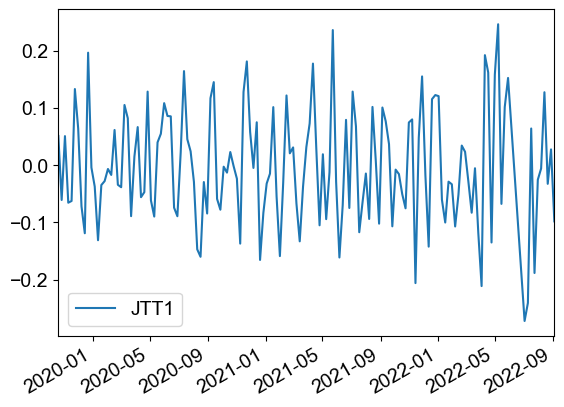

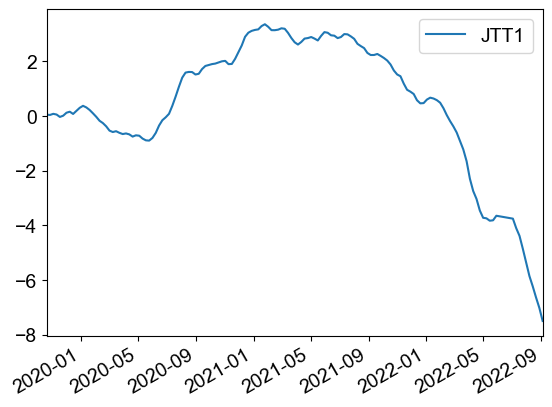

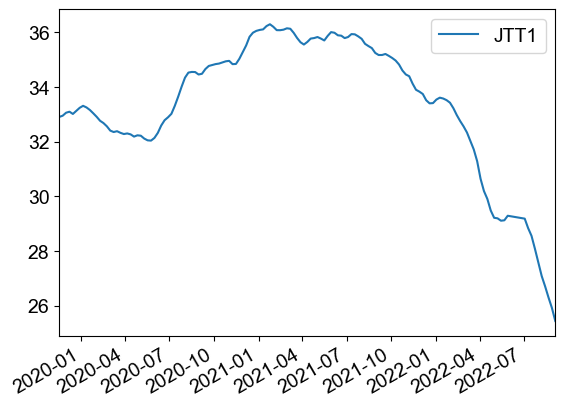

In [282]:
# get back to original by undoing double differencing
estimate.plot()
y_diff1_recovered = np.cumsum(estimate.dropna())  # First differencing reversal, need to drop nans
y_recovered = np.cumsum(y_diff1_recovered)

y_recovered.plot()

# adding difference
y_original = file.iloc[:,0]
diff = y_original.iloc[shift_start+2] - y_recovered.iloc[0,0] # +2 for double differencing
y_recovered = y_recovered+diff
y_recovered[:shift_start] = np.nan # need to add nans as these are not estimated
y_recovered.plot()

In [258]:
diff = y_original.iloc[shift_start+2] - y_recovered.iloc[shift_start,0] # +2 for double differencing
diff

nan

CHECK MAX LAG AND ADD BEFORE ESTIMATION!


C:\Users\andregas\AppData\Local\Temp\ipykernel_21172\914343710.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate[t] = (sum(lags_1[i-1] * file[lg1][t-i] for i in range(1, max_lag_1+1)) +
C:\Users\andregas\AppData\Local\Temp\ipykernel_21172\914343710.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(lags_4[j] * file[lg4][t-j] for j in range(max_lag_4+1))) #+


The RMSE of the model is: 0.18429352780207378


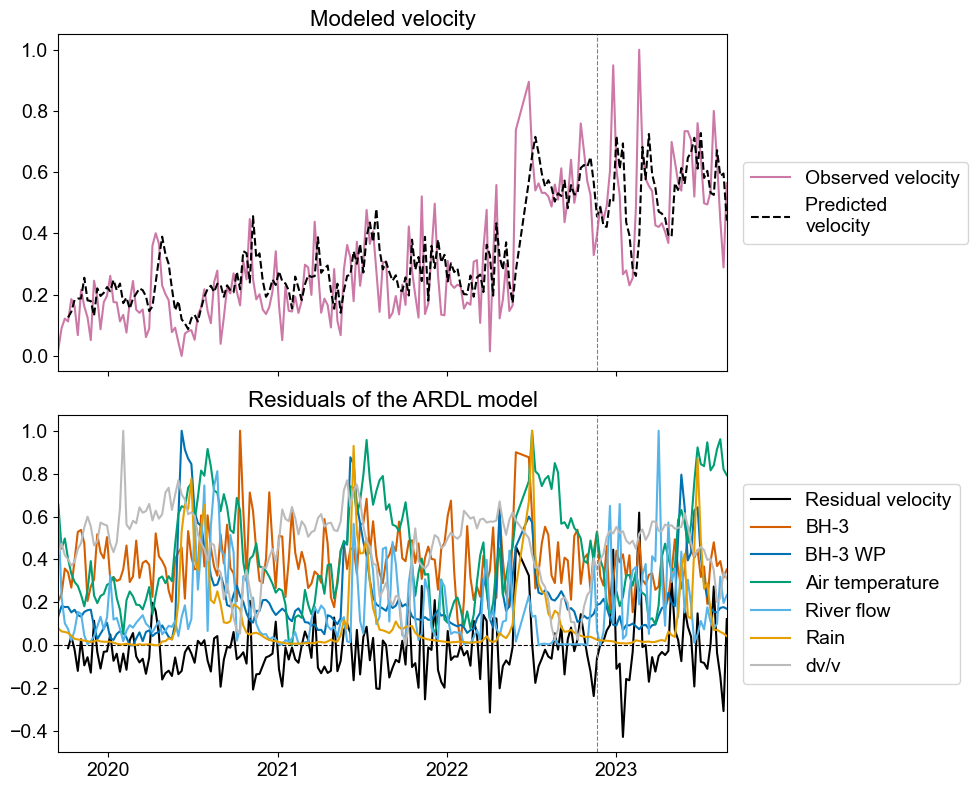

In [21]:
## with AR part 

# Try to make a better figure
print('CHECK MAX LAG AND ADD BEFORE ESTIMATION!')

# initiate for the if in plotting
estimate = []
predictions = []

lg1 = 'JTT1'
# lg2 = 'JTT2-L'
# lg3 = 'JTT2-L WP'
lg4 = 'JTT3'
lg5 = 'JTT3 WP'
lg6 = 'Temp'
lg7 = 'Precip'
lg8 = 'River'
lg9 = 'dv/v'

max_lag_1 = get_max_lag(lg1)
# max_lag_2 = get_max_lag(lg2)
# max_lag_3 = get_max_lag(lg3)
max_lag_4 = get_max_lag(lg4)
# max_lag_5 = get_max_lag(lg5)
# max_lag_6 = get_max_lag(lg6)
# max_lag_7 = get_max_lag(lg7)
# max_lag_8 = get_max_lag(lg8)

# # Non-linear part
# max_lag_6 = get_max_lag(stripped_names[5])
# max_lag_7 = get_max_lag(stripped_names[6])

# model_parameters = params.copy() # also non-significant, but need to fix max lag if using it..
model_parameters = significant_params.copy() # significant

# const = model_parameters.get('const', 0)  # Use 0 if no intercept is included
lags_1 = [model_parameters.get(f'{lg1}.L{i}', 0) for i in range(1, max_lag_1+1)] # 0 equals constant and if model set to trend 'n', there is none.
# lags_2 = [model_parameters.get(f'{lg2}.L{i}', 0) for i in range(max_lag_2+1)]
# lags_3 = [model_parameters.get(f'{lg3}.L{i}', 0) for i in range(max_lag_3+1)]
lags_4 = [model_parameters.get(f'{lg4}.L{i}', 0) for i in range(max_lag_4+1)]
# lags_5 = [model_parameters.get(f'{lg5}.L{i}', 0) for i in range(max_lag_5+1)]


# # # Non-linear part
# lags_6 = [model_parameters.get(f'{stripped_names[5]}.L{i}', 0) for i in range(max_lag_6+1)]
# lags_7 = [model_parameters.get(f'{stripped_names[6]}.L{i}', 0) for i in range(max_lag_7+1)]

### choosing dataset, predicting or verifying ? ####
# # verifying
predicting_future = False
file = df_train.copy() # scaled dataset before separating to response and explanatory to verify prediction

# # Predicting?   # something is wrong when using the df_original
predicting_future = True
file = scaled_combined.copy() # predicting # The original data with the seasonal component. Since it is so off it might need the trend component as well? But that would not help as it is majorly off.
####################################################

# Initialize estimate array
num_days = len(file)
estimate = np.zeros(num_days)
shift_start = 3 # max(max_lag_1, max_lag_4) # make this code take the highest value from parameters
estimate[:shift_start] = np.nan  # NaN for the first round of lags

# Calculate fitted values (estimate) manually with AR part
for t in range(shift_start, num_days):  # Starting from correct lag to avoid undefined lags
    estimate[t] = (sum(lags_1[i-1] * file[lg1][t-i] for i in range(1, max_lag_1+1)) +
                   sum(lags_4[j] * file[lg4][t-j] for j in range(max_lag_4+1))) #+
                   # sum(lags_3[j] * file[lg3][t-j] for j in range(max_lag_3+1)) +
                   # sum(lags_4[j] * file[lg4][t-j] for j in range(max_lag_4+1)) +
                   # sum(lags_5[j] * file[lg5][t-j] for j in range(max_lag_5+1))) # +
                   # sum(lags_6[j] * explanatory[lg6][t-j] for j in range(max_lag_6+1)))


# # automatic predictions
# predictions = m1.predict()
# conf_int = pred_obj.conf_int() # is it confidence intervals for this model?

### plotting data
fig = plt.figure(figsize=(10, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])  # 2:1 ratio for ax1 and ax2

# if not inverse transform
estimate = pd.DataFrame(estimate, index=file.index)

# Plot the original data and estimated displacement on the first subplot
# # Transform back to original values
# estimate = pd.DataFrame(estimate, index=response.index) # to a df so possible to concat
# combined_original = pd.DataFrame(scaler.inverse_transform(pd.concat([estimate, explanatory], axis=1)), columns=df_features.columns, index=df_features.index)
# # Separate back into response and explanatory
# estimate = combined_original[[df_features.columns[0]]]
# # explanatory_original = combined_original[[df_features.columns[1]]]


ax1 = fig.add_subplot(gs[0])

# # original
# ax1.plot(file.index, file[file.columns[0]])      
# ax1.plot(file.index, file[file.columns[1]])

# scaled
ax1.plot(file.index, file[lg1], label='Observed velocity', color=colors[0])      
# ax1.plot(explanatory.index, explanatory[lg2], label= 'Water pressure', color=colors[1])
# ax1.plot(explanatory.index, explanatory[lg3], label= 'Air temperature', color=colors[2])
# ax1.plot(explanatory.index, explanatory[lg4], label= 'River flow', color=colors[4])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[3]], label= f'{explanatory.columns[3]}')
# ax1.plot(explanatory.index, explanatory[explanatory.columns[4]], label= f'{explanatory.columns[4]}')
# ax1.plot(explanatory.index, explanatory[explanatory.columns[5]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[6]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[7]])


ax1.plot(file.index, estimate, linestyle='dashed', label='Predicted \nvelocity', color=colors[7])

# ax1.plot(response.index, predictions, linestyle='dashed', label='Predicted \nvelocity', color=colors[7])
    
# if not pd.Series(predictions).empty:
#   ax1.plot(response.index, predictions, linestyle='dashed')  
#     # ax1.fill_between(file.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
    
ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.5)) # [f'{response.columns[0]}', f'{explanatory.columns[0]}', f'{explanatory.columns[1]}', f'{explanatory.columns[2]}', f'{explanatory.columns[3]}', 'Predicted displacement'],

# ax1.legend(['Displacement', 'Water pressure', 'Estimated significant coeffs'], ncol=2, loc='upper center')
# ax1.set_ylim(0, 1.5)
ax1.set_title('Modeled velocity')


# Plot the residuals on the second subplot
ax2 = fig.add_subplot(gs[1])

ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

ax2.plot(file.index, (file[file.columns[0]] - estimate[estimate.columns[0]]), label='Residual velocity', color=colors[7])
ax2.plot(file.index, file[lg4], label= 'BH-3', color=colors[1])
ax2.plot(file.index, file[lg5], label= 'BH-3 WP', color=colors[2])
ax2.plot(file.index, file[lg6], label= 'Air temperature', color=colors[4])
ax2.plot(file.index, file[lg7], label= 'River flow', color=colors[5])
ax2.plot(file.index, file[lg8], label= 'Rain', color=colors[6])
ax2.plot(file.index, file[lg9], label= 'dv/v', color=colors[8])


ax2.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
ax2.set_title('Residuals of the ARDL model')

# hihglighting predicting data
if predicting_future:
    ax1.axvline(x=file.iloc[file.index.get_indexer([cutoff_index], method='nearest')[0]].name, color='gray', linestyle='--', linewidth=0.8)  # Vertical line indicating end of training data
    ax2.axvline(x=file.iloc[file.index.get_indexer([cutoff_index], method='nearest')[0]].name, color='gray', linestyle='--', linewidth=0.8)  # Vertical line indicating end of training data

# cosmetics
# Set major ticks format to display only years
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_xticklabels([])

ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


# # zoom on a window
# ax1.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))
# ax2.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))

plt.tight_layout()

# # # saving
path = 'plots\\'
save_name = f'{path}Figure8_wAR.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'

# Compute RMSE on the predicted data
residuals = file.loc[df_test.index,'JTT1'].values - estimate.loc[df_test.index][0].values
rmse = np.sqrt(np.mean(residuals**2))

print(f"The RMSE of the model is: {rmse}")

CHECK MAX LAG AND ADD BEFORE ESTIMATION!


C:\Users\andregas\AppData\Local\Temp\ipykernel_21172\482230835.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate[t] = (sum(lags_4[j] * file[lg4][t-j] for j in range(max_lag_4+1)) +
C:\Users\andregas\AppData\Local\Temp\ipykernel_21172\482230835.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(lags_5[j] * file[lg5][t-j] for j in range(max_lag_5+1)) +
C:\Users\andregas\AppData\Local\Temp\ipykernel_21172\482230835.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

The RMSE of the model is: 0.4181495140820697


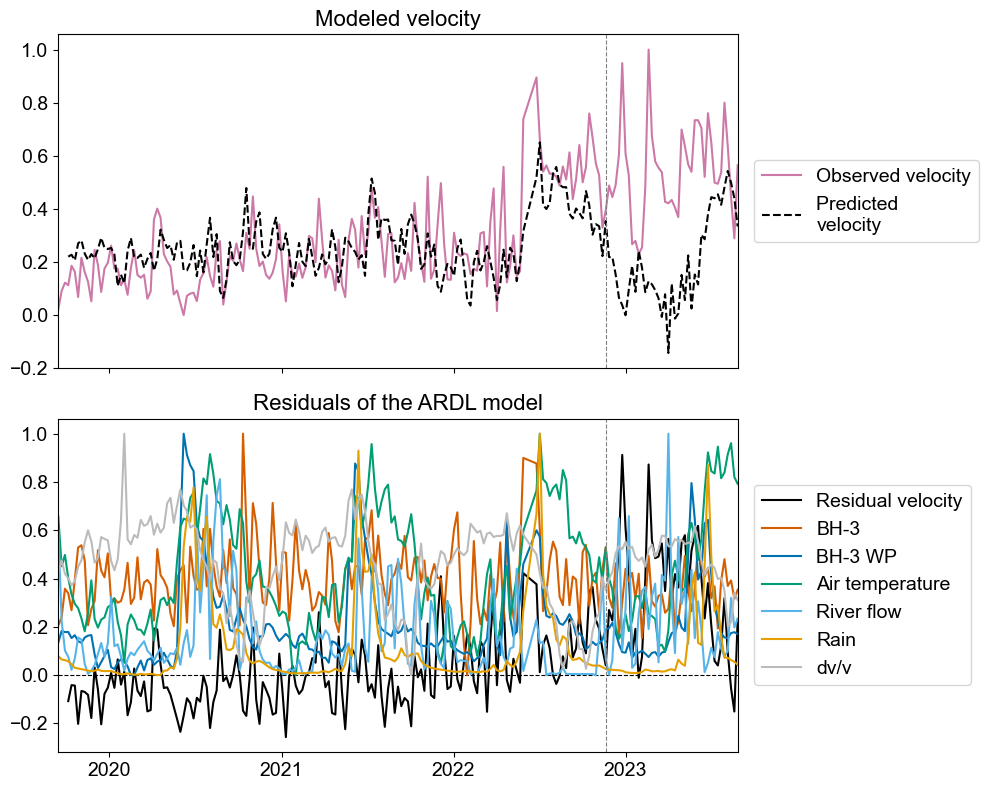

In [25]:
## Without AR part
# Try to make a better figure

# initiate for the if in plotting
estimate = []
predictions = []

lg1 = 'JTT1'
# lg2 = 'JTT2-L'
# lg3 = 'JTT2-L WP'
lg4 = 'JTT3'
lg5 = 'JTT3 WP'
lg6 = 'Temp'
lg7 = 'Precip'
lg8 = 'River'

# Try to make a better figure
print('CHECK MAX LAG AND ADD BEFORE ESTIMATION!')

# initiate for the if in plotting
estimate = []
predictions = []

lg1 = 'JTT1'
# lg2 = 'JTT2-L'
# lg3 = 'JTT2-L WP'
lg4 = 'JTT3'
lg5 = 'JTT3 WP'
lg6 = 'Temp'
lg7 = 'Precip'
lg8 = 'River'
lg9 = 'dv/v'

max_lag_1 = get_max_lag(lg1)
# max_lag_2 = get_max_lag(lg2)
# max_lag_3 = get_max_lag(lg3)
max_lag_4 = get_max_lag(lg4)
max_lag_5 = get_max_lag(lg5)
max_lag_6 = get_max_lag(lg6)
max_lag_7 = get_max_lag(lg7)
# max_lag_8 = get_max_lag(lg8)

# # Non-linear part
# max_lag_6 = get_max_lag(stripped_names[5])
# max_lag_7 = get_max_lag(stripped_names[6])

# model_parameters = params.copy() # also non-significant, but need to fix max lag if using it..
model_parameters = significant_params.copy() # significant

# const = model_parameters.get('const', 0)  # Use 0 if no intercept is included
lags_1 = [model_parameters.get(f'{lg1}.L{i}', 0) for i in range(1, max_lag_1+1)] # 0 equals constant and if model set to trend 'n', there is none.
# lags_2 = [model_parameters.get(f'{lg2}.L{i}', 0) for i in range(max_lag_2+1)]
# lags_3 = [model_parameters.get(f'{lg3}.L{i}', 0) for i in range(max_lag_3+1)]
lags_4 = [model_parameters.get(f'{lg4}.L{i}', 0) for i in range(max_lag_4+1)]
lags_5 = [model_parameters.get(f'{lg5}.L{i}', 0) for i in range(max_lag_5+1)]
lags_6 = [model_parameters.get(f'{lg6}.L{i}', 0) for i in range(max_lag_6+1)]
lags_7 = [model_parameters.get(f'{lg7}.L{i}', 0) for i in range(max_lag_7+1)]

# # # Non-linear part
# lags_6 = [model_parameters.get(f'{stripped_names[5]}.L{i}', 0) for i in range(max_lag_6+1)]
# lags_7 = [model_parameters.get(f'{stripped_names[6]}.L{i}', 0) for i in range(max_lag_7+1)]

### choosing dataset, predicting or verifying ? ####
# # verifying
predicting_future = False
file = df_train.copy() # scaled dataset before separating to response and explanatory to verify prediction

# # Predicting?   # something is wrong when using the df_original
predicting_future = True
file = scaled_combined.copy() # predicting # The original data with the seasonal component. Since it is so off it might need the trend component as well? But that would not help as it is majorly off.
####################################################

# Initialize estimate array
num_days = len(file)
estimate = np.zeros(num_days)
shift_start = 3 # max(max_lag_1, max_lag_4) # make this code take the highest value from parameters
estimate[:shift_start] = np.nan  # NaN for the first round of lags


# Calculate fitted values (estimate) manually without AR part
for t in range(shift_start, num_days):  # Starting from correct lag to avoid undefined lags
    estimate[t] = (sum(lags_4[j] * file[lg4][t-j] for j in range(max_lag_4+1)) +
                   sum(lags_5[j] * file[lg5][t-j] for j in range(max_lag_5+1)) +
                   sum(lags_6[j] * file[lg6][t-j] for j in range(max_lag_6+1)) +
                   sum(lags_7[j] * file[lg7][t-j] for j in range(max_lag_7+1)))


# # automatic predictions
# predictions = m1.predict()
# conf_int = pred_obj.conf_int() # is it confidence intervals for this model?

### plotting data
fig = plt.figure(figsize=(10, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])  # 2:1 ratio for ax1 and ax2

# if not inverse transform
estimate = pd.DataFrame(estimate, index=file.index)

# Plot the original data and estimated displacement on the first subplot
# # Transform back to original values
# estimate = pd.DataFrame(estimate, index=response.index) # to a df so possible to concat
# combined_original = pd.DataFrame(scaler.inverse_transform(pd.concat([estimate, explanatory], axis=1)), columns=df_features.columns, index=df_features.index)
# # Separate back into response and explanatory
# estimate = combined_original[[df_features.columns[0]]]
# # explanatory_original = combined_original[[df_features.columns[1]]]


ax1 = fig.add_subplot(gs[0])

# # original
# ax1.plot(file.index, file[file.columns[0]])      
# ax1.plot(file.index, file[file.columns[1]])

# scaled
ax1.plot(file.index, file[lg1], label='Observed velocity', color=colors[0])      
# ax1.plot(explanatory.index, explanatory[lg2], label= 'Water pressure', color=colors[1])
# ax1.plot(explanatory.index, explanatory[lg3], label= 'Air temperature', color=colors[2])
# ax1.plot(explanatory.index, explanatory[lg4], label= 'River flow', color=colors[4])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[3]], label= f'{explanatory.columns[3]}')
# ax1.plot(explanatory.index, explanatory[explanatory.columns[4]], label= f'{explanatory.columns[4]}')
# ax1.plot(explanatory.index, explanatory[explanatory.columns[5]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[6]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[7]])


ax1.plot(file.index, estimate, linestyle='dashed', label='Predicted \nvelocity', color=colors[7])

# ax1.plot(response.index, predictions, linestyle='dashed', label='Predicted \nvelocity', color=colors[7])
    
# if not pd.Series(predictions).empty:
#   ax1.plot(response.index, predictions, linestyle='dashed')  
#     # ax1.fill_between(file.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
    
ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.5)) # [f'{response.columns[0]}', f'{explanatory.columns[0]}', f'{explanatory.columns[1]}', f'{explanatory.columns[2]}', f'{explanatory.columns[3]}', 'Predicted displacement'],

# ax1.legend(['Displacement', 'Water pressure', 'Estimated significant coeffs'], ncol=2, loc='upper center')
# ax1.set_ylim(0, 1.5)
ax1.set_title('Modeled velocity')


# Plot the residuals on the second subplot
ax2 = fig.add_subplot(gs[1])

ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

ax2.plot(file.index, (file[file.columns[0]] - estimate[estimate.columns[0]]), label='Residual velocity', color=colors[7])
ax2.plot(file.index, file[lg4], label= 'BH-3', color=colors[1])
ax2.plot(file.index, file[lg5], label= 'BH-3 WP', color=colors[2])
ax2.plot(file.index, file[lg6], label= 'Air temperature', color=colors[4])
ax2.plot(file.index, file[lg7], label= 'River flow', color=colors[5])
ax2.plot(file.index, file[lg8], label= 'Rain', color=colors[6])
ax2.plot(file.index, file[lg9], label= 'dv/v', color=colors[8])


ax2.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
ax2.set_title('Residuals of the ARDL model')

# hihglighting predicting data
if predicting_future:
    ax1.axvline(x=file.iloc[file.index.get_indexer([cutoff_index], method='nearest')[0]].name, color='gray', linestyle='--', linewidth=0.8)  # Vertical line indicating end of training data
    ax2.axvline(x=file.iloc[file.index.get_indexer([cutoff_index], method='nearest')[0]].name, color='gray', linestyle='--', linewidth=0.8)  # Vertical line indicating end of training data

# cosmetics
# Set major ticks format to display only years
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_xticklabels([])

ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


# # zoom on a window
# ax1.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))
# ax2.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))

plt.tight_layout()

# # # saving
path = 'plots\\'
save_name = f'{path}Figure8_woutAR.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'

# Compute RMSE on the predicted data
residuals = file.loc[df_test.index,'JTT1'].values - estimate.loc[df_test.index][0].values
rmse = np.sqrt(np.mean(residuals**2))

print(f"The RMSE of the model is: {rmse}")
